<font size="+5">
(5), (6), (8) Below = things to check with Mihail!
</font>

In [ ]:
# TODO:
# (1) Once the script is set in stone add this syntax to all of the function headers"
'''
describe what function does

@param file_name:
@param 2/...:

@return:

@throws: do this if throws an exception
'''
# 
# (2) get rid of idx += 1 use enumerate instead
#
# (3) Use np.zeros_like , np.array_like to make an array of the same size whenever possible
# 
# (4) when/if decide to normalize it do it for the entire stack not on a per image basis --> don't lose dynamic range
# 
# (5) is there a better way to loop through rows and cols pythonically? --> fine toe keep
# 
# (6) what was the image from the  text that you sent me? --> x = (,) can do np.zeros([*x])
# 
# (7) processing: convolutions?, mean, median, sum (not the same bc if neuron is bigger the sum will be bigger but
# not a big deal if on a per neuron basis)?, thresholding?, time series?
# 
# (8) Is there a reason median across time takes so much longer than mean or sum across time? y

# IMPORTANT COMMENTS!!!
# # The median array is not the same as the mean or sum array
# But the mean and sum array for percentile cutoffs are the same --> DUHHHHH


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import skimage.io as skimage

from collections import defaultdict
from collections import namedtuple
from glob import glob
from random import shuffle
from scipy import signal
from scipy.ndimage import measurements

In [2]:
'''
takes a list of lab names, iterates through file names, and puts file names into a 
dictionary cooresponding to lab name with in the file
'''
def seperate_file_names_by_lab(lab_names, files):
    lab_names_to_files = defaultdict(list)
    
    for file in files:
        lab_name_found = False
        for lab_name in lab_names:
            if re.search(lab_name, file):
                lab_names_to_files[lab_name].append(file)
                lab_name_found = True
        if not lab_name_found:
            print('error file name: ' + file + ' not found in lab names')
            
    return lab_names_to_files

In [3]:
INITIAL_DATA_GLOB = glob('/Users/sabera.talukder/Desktop/anithaTestData/*.tiff')
files = sorted(INITIAL_DATA_GLOB)

In [4]:
NUM_P200_FILES = 8000
NUM_P300_FILES = 2250
lab_names = ['_p200', '_p300']

# split data files based on lab name
lab_names_to_files = seperate_file_names_by_lab(lab_names, files)

# assert just checks to make sure the statement is true and if it is not returns the comment to its right
assert len(lab_names_to_files['_p200']) == NUM_P200_FILES, 'missing files'
assert len(lab_names_to_files['_p300']) == NUM_P300_FILES, 'missing files'

files_200 = np.array(lab_names_to_files['_p200'])
files_300 = np.array(lab_names_to_files['_p300'])

In [5]:
'''
-find all integers (C,Z,T,P) in the file name, returns a list of those integers
-r signifies that the following argument is a string
-the '\d+' signifies that we are looking for a digit
-the integer values we get from the files are in the order C, Z, T, P
'''
def find_integers_in_file_name(file_name):
    string_list_C_Z_T_P = re.findall(r'\d+', file_name)
    int_list_C_Z_T_P = list(map(int, string_list_C_Z_T_P))
    return int_list_C_Z_T_P

In [6]:
'''
make sure that our final file lists are sorted by the time idx
(we are verifying that sorted() actually did its job)
'''
def verify_files_sorted_by_time(file_names):
    for idx in range(0, len(file_names)-1):
        first_file_vals = find_integers_in_file_name(file_names[idx])
        second_file_vals = find_integers_in_file_name(file_names[idx + 1])
        if not first_file_vals[2] < second_file_vals[2]:
            print('Time values are not in increasing order. The idx this occured at is: ' + str(idx))
            return False
    return True

In [7]:
print(verify_files_sorted_by_time(files_200))
print(verify_files_sorted_by_time(files_300))

True
True


In [8]:
def convert_file_names_to_img_arr(file_name_list):
    return np.array([skimage.imread(f) for f in file_name_list])

In [9]:
imgs_200 = convert_file_names_to_img_arr(files_200)

In [10]:
imgs_300 = convert_file_names_to_img_arr(files_300)

In [11]:
IMG_SHAPE_200 = imgs_200.shape[1:]
IMG_SHAPE_300 = imgs_300.shape[1:]

In [12]:
'''
Loads the json file
Takes in path, and outputs list of dicts.
'''
def read_in_neuron_masks(neuron_mask_path):
    with open(neuron_mask_path) as file:
        regions = json.load(file)
    return regions

In [13]:
regions_200 = read_in_neuron_masks('neurofinder.02.00/regions/regions.json')
regions_300 = read_in_neuron_masks('neurofinder.03.00/regions/regions.json')

In [14]:
'''
Takes in coords: which is a list of all of the pixel values in the form [[x1,y1],[x2,y2],...]
Takes in dims: which is a tuple of the 2d array dimensions

returns a 2d mask where the shape of a neuron is filled in with pixel values of 1
'''
def fill_in_pixel_vals(coords, dims):
    mask = np.zeros(dims)
    for coord in coords:
        mask[coord[0], coord[1]] = 1
    return mask

In [15]:
'''
Takes in a list of dicts, each dict contains all of the coordinate values for one neuron mask
Takes in img_shape_tuple: which is a tuple of the 2d array dimensions

Loops through the dictionaries and calls fill_in_pixel_vals() to fill in the pixel values

Returns a 3d array with dimensions: (# of neurons, x dim of array, y dim of array)
'''
def go_from_dict_vals_to_masks(regions, img_shape_tuple):
    KEY_FOR_MASK_DICTS = 'coordinates'
    mask_array = np.zeros([len(regions), img_shape_tuple[0], img_shape_tuple[1]])
    
#     TODO pick a better name than dictionary
    for idx, dictionary in enumerate(regions):
        mask_array[idx, :, :] = fill_in_pixel_vals(dictionary[KEY_FOR_MASK_DICTS],img_shape_tuple)
    return mask_array

In [16]:
masks_200 = go_from_dict_vals_to_masks(regions_200, IMG_SHAPE_200)
masks_300 = go_from_dict_vals_to_masks(regions_300, IMG_SHAPE_300)

In [17]:
neuron_mask = namedtuple('neuron_mask', ['num_neuron', 'num_pixels', 'x_min', 'y_min', 'x_max', 'y_max'])

In [18]:
'''
Takes in a 3d array that contains all of the masks

Outputs a list of named tuples containing the neuron idx in the total mask, the number of pixels in that mask, then
x_min, y_min, x_max, y_max which will allow us to create a bounding box around all of our neurons
'''
def get_neuron_mask_info(total_mask_array):
    neuron_info = []
    for idx, mask in enumerate(total_mask_array):
        # returns the unique pixel values, and the number of times each of those pixel values appear in the img
        unique, counts = np.unique(mask, return_counts=True)
        # returns an array with x indicies, and an array with y indicies wherever the pixel was == 1
        test = np.where(mask == 1)
        neuron = neuron_mask(num_neuron=idx, num_pixels = counts[-1], x_min = np.min(test[0]), \
                             y_min = np.min(test[1]), x_max = np.max(test[0]), y_max = np.max(test[1]))
        neuron_info.append(neuron)
    return neuron_info

In [19]:
masks_200_info = get_neuron_mask_info(masks_200)
masks_300_info = get_neuron_mask_info(masks_300)

<font size='+3'>
^ UP until that point is processing and generating DATA
</font>

In [20]:
'''
Can pass in 'median', 'mean', 'sum'
'''
def neuron_image_evaluation(filter_type, neuron_2d_array):
    if filter_type == 'median':
        return np.median(neuron_2d_array)
    elif filter_type == 'mean':
        return np.mean(neuron_2d_array)
    elif filter_type == 'sum':
        return np.sum(neuron_2d_array)
    else:
        print('error did not pass a valid string argument')

In [21]:
'''
-takes in the mask information (area, bounding box, etc, in the form of a list of named tuples)
-the total mask array, which is a 3d array of all of the masks for a full stack (#neurons, x_dim, y_dim)
-takes in the stack of all of the imgs (#time_steps, x_dim, y_dim)
-takes in how_to_evaluate_neuron which is the median, mean, sum that the neuron_image_evaluation() returns

-returns a 2d array with size (# of neurons, # of imgs in the time series)
-each value in the array will be the median/mean/or sum of the pixels that fill the neuron bounding box in that img
'''
def neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, how_to_evaluate_neuron):
    neuron_across_time_series = np.zeros([total_mask_array.shape[0], img_stack.shape[0]])
    
    for mask_idx, neuron in enumerate(mask_info):
        cur_info = mask_info[mask_idx]
        mask = total_mask_array[mask_idx, cur_info.x_min : cur_info.x_max, cur_info.y_min : cur_info.y_max]
        
        for time_idx, img in enumerate(img_stack):
            img_segment = img[cur_info.x_min : cur_info.x_max, cur_info.y_min : cur_info.y_max]
            neuron = mask * img_segment
            m_m_or_s_val = neuron_image_evaluation(how_to_evaluate_neuron, neuron)
            neuron_across_time_series[mask_idx, time_idx] = m_m_or_s_val
            
    return neuron_across_time_series

In [22]:
'''
-Takes the neuron versus time stack and finds the top x percent for each neuron i.e. for each row
-returns a 1d array (# neurons, 1) with what the actual percentile value is per neuron
'''
# change name compute percentile per neuron÷\
def what_is_percentile_val_per_neuron(neuron_and_time_stack, percentile):
    NUM_NEURONS = neuron_and_time_stack.shape[0]
    percentile_val_per_neuron = np.zeros([NUM_NEURONS, 1])
    for row in range(0, NUM_NEURONS):
        percentile_val = np.percentile(neuron_and_time_stack[row, :], percentile)
        percentile_val_per_neuron[row, 0] = percentile_val
    return percentile_val_per_neuron

In [23]:
# THIS IS THE OLD VERSION WILL BE DELETED
'''
-now that we have the Xth percentile for every neuron across the time series we need to extract the image
indicies where the neural mask value (median, mean, sum) lies above the Xth percentile
'''
# change to 0,1, array
# maybe sparse if can transpose
def img_indicies_where_neuron_val_above_percentile(percentile_vals, neuron_across_time_series):
    NUM_NEURONS = percentile_vals.shape[0] # = neuron_across_time_series.shape[0]
    # The row number of img_indicies indicates the neuron the img likely has
    # The values in inner [] are the time stamps of the img where the neuron we are looking at appears (i.e. the col #)
    img_time_indicies = []
    for row in range(0, NUM_NEURONS):
        percential_val = percentile_vals[row,0]
        img_nums_where_neuron_is_high = []
        for col in range(0, neuron_across_time_series.shape[1]):
            #changed from >= to be > --> did not make much of a difference
            if neuron_across_time_series[row, col] > percential_val:
                img_nums_where_neuron_is_high.append(col)
        img_time_indicies.append(img_nums_where_neuron_is_high)
    return img_time_indicies

In [41]:
'''
-now that we have the Xth percentile for every neuron across the time series we need indicate the image
indicies where the neural mask value (median, mean, sum) lies above the Xth percentile

-output will be an array of neuron # vs image # i.e. 197 by 8000
-1 indicates that that neuron appears in that image 
-0 indicates that that neuron does not appear in that image
'''
# change to 0,1, array
# maybe sparse if can transpose
def array_where_neuron_val_above_percentile(percentile_vals, neuron_across_time_series):
    NUM_NEURONS = percentile_vals.shape[0] # = neuron_across_time_series.shape[0]
    # The row number of img_indicies indicates the neuron the img likely has
    # The values in inner [] are the time stamps of the img where the neuron we are looking at appears (i.e. the col #)
    neuron_mask_present_in_img = np.zeros_like(neuron_across_time_series)
    for row in range(0, NUM_NEURONS):
        percential_val = percentile_vals[row,0]
        for col in range(0, neuron_across_time_series.shape[1]):
            if neuron_across_time_series[row, col] > percential_val:
                neuron_mask_present_in_img[row, col] = 1
    return neuron_mask_present_in_img

In [25]:
'''
-Since the arrays are all 0s or 1s if we multiply them together only the neuron values that are above the Xth
percentile for all 3 metrics will be represented
'''
def combine_median_mean(median_array, mean_array):
    above_percentile_in_med_mean = median_array * mean_array
    return above_percentile_in_med_mean

In [26]:
'''remapping the 2d array so instead of having rows = neuron number and cols = image number
the rows will be an image number and the cols will be the neuron number

This way we can take an entire row and plot what the total mask would look like for that image
the 2d array will be the # of imgs in the stack by the # of neurons

the values in the array will either be a 0 or a 1 --> 0 indicates that at that percentile value the neuron is
not on in that image, the 1 indiciates that the neuron is in in that image

for example our array will be 8000 by 197
we can then take each row (each image and create the mask that the 90% percentile demonstrates)'''
# transpose
def rearrange_to_be_img_versus_neuron(high_img_indicies, time_series_len, total_num_neurons):
    img_versus_neuron_array = np.zeros([time_series_len, total_num_neurons])
    for num_neuron in range(0, len(high_img_indicies)):
        for img_idx in range(0, len(high_img_indicies[num_neuron])):
            img_versus_neuron_array[high_img_indicies[num_neuron][img_idx], num_neuron] = 1
    return img_versus_neuron_array

In [27]:
'''
Don't need this function anymore becuase retooled img_indicies_where_neuron_val_above_percentile
to be array_where_neuron_val_above_percentile

'''
def return_total_masks(array_masks_per_img, all_masks, all_imgs):
    NEURON_NUM = all_masks.shape[0]
    TIME_SERIES_NUM = all_imgs.shape[0]
    IMG_X_DIM = all_imgs.shape[1] #This is the same dimension as all_masks.shape[1]
    IMG_Y_DIM = all_imgs.shape[2] #This is the same dimension as all_masks.shape[2]
    total_masks_for_imgs = np.zeros([TIME_SERIES_NUM, IMG_X_DIM, IMG_Y_DIM])
    
    for row in range(0, TIME_SERIES_NUM):
        total_mask = np.zeros([IMG_X_DIM, IMG_Y_DIM])
        for col in range(0, NEURON_NUM):
            if array_masks_per_img[row, col] == 1:
                total_mask = total_mask + all_masks[col, :, :]
        total_masks_for_imgs[row, :, :] = total_mask
    return total_masks_for_imgs

In [28]:
def generate_all_masks(mask_info, total_mask_array, img_stack, how_to_evaluate_neuron, percentile_selectivity,):
    print('entered function')
    TOTAL_NUM_TIME_STEPS = img_stack.shape[0]
    TOTAL_NUM_NEURONS = total_mask_array.shape[0]
    print('TOTAL_NUM_TIME_STEPS = '+ str(TOTAL_NUM_TIME_STEPS) +', TOTAL_NUM_NEURONS = ' + str(TOTAL_NUM_NEURONS))
    neuron_eval_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, how_to_evaluate_neuron)
    print('post neuron eval')
    percentile_value_per_neuron = what_is_percentile_val_per_neuron(neuron_eval_across_time, percentile_selectivity)
    print('post percentile gen')
    # below has to be changed to array_where_neuron_val_above_percentile
    img_inds_where_neuron_high = img_indicies_where_neuron_val_above_percentile(percentile_value_per_neuron, neuron_eval_across_time)
    print('found indicies above percentile')
    masks_per_img = rearrange_to_be_img_versus_neuron(img_inds_where_neuron_high, TOTAL_NUM_TIME_STEPS, TOTAL_NUM_NEURONS)
    print('found all masks per image')
    total_masks_for_all_time_series = return_total_masks(masks_per_img, total_mask_array, img_stack)
    return total_masks_for_all_time_series

<font size='+3'>
UP until that point extracting masks based on a percentile value
</font>

In [37]:
def temp_which_percentile(percentile_selectivity, mask_info, total_mask_array, img_stack):
#     mask_info = masks_200_info
#     total_mask_array = masks_200
#     img_stack = imgs_200
    TOTAL_NUM_TIME_STEPS = img_stack.shape[0]
    TOTAL_NUM_NEURONS = total_mask_array.shape[0]

    neuron_med_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'median')
    neuron_mean_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'mean')

    percentile_val_per_neuron_med = what_is_percentile_val_per_neuron(neuron_med_across_time, percentile_selectivity)
    percentile_val_per_neuron_mean = what_is_percentile_val_per_neuron(neuron_mean_across_time, percentile_selectivity)

    neuron_med_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_med, neuron_med_across_time)
    neuron_mean_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_mean, neuron_mean_across_time)
    
    combined_percentiles = combine_median_mean(neuron_med_above_percentile, neuron_mean_above_percentile)
    
    all_masks = return_total_masks(np.transpose(combined_percentiles), total_mask_array, img_stack)
    
    return all_masks
    

In [42]:
masks_200_percentile_87 = temp_which_percentile(87, masks_200_info, masks_200, imgs_200)

In [49]:
masks_300_percentile_87 = temp_which_percentile(87, masks_300_info, masks_300, imgs_300)

In [63]:
np.save('lab_200_masks_no_time_series_percentile_87', masks_200_percentile_87)

In [64]:
np.save('lab_300_masks_no_time_series_percentile_87', masks_300_percentile_87)

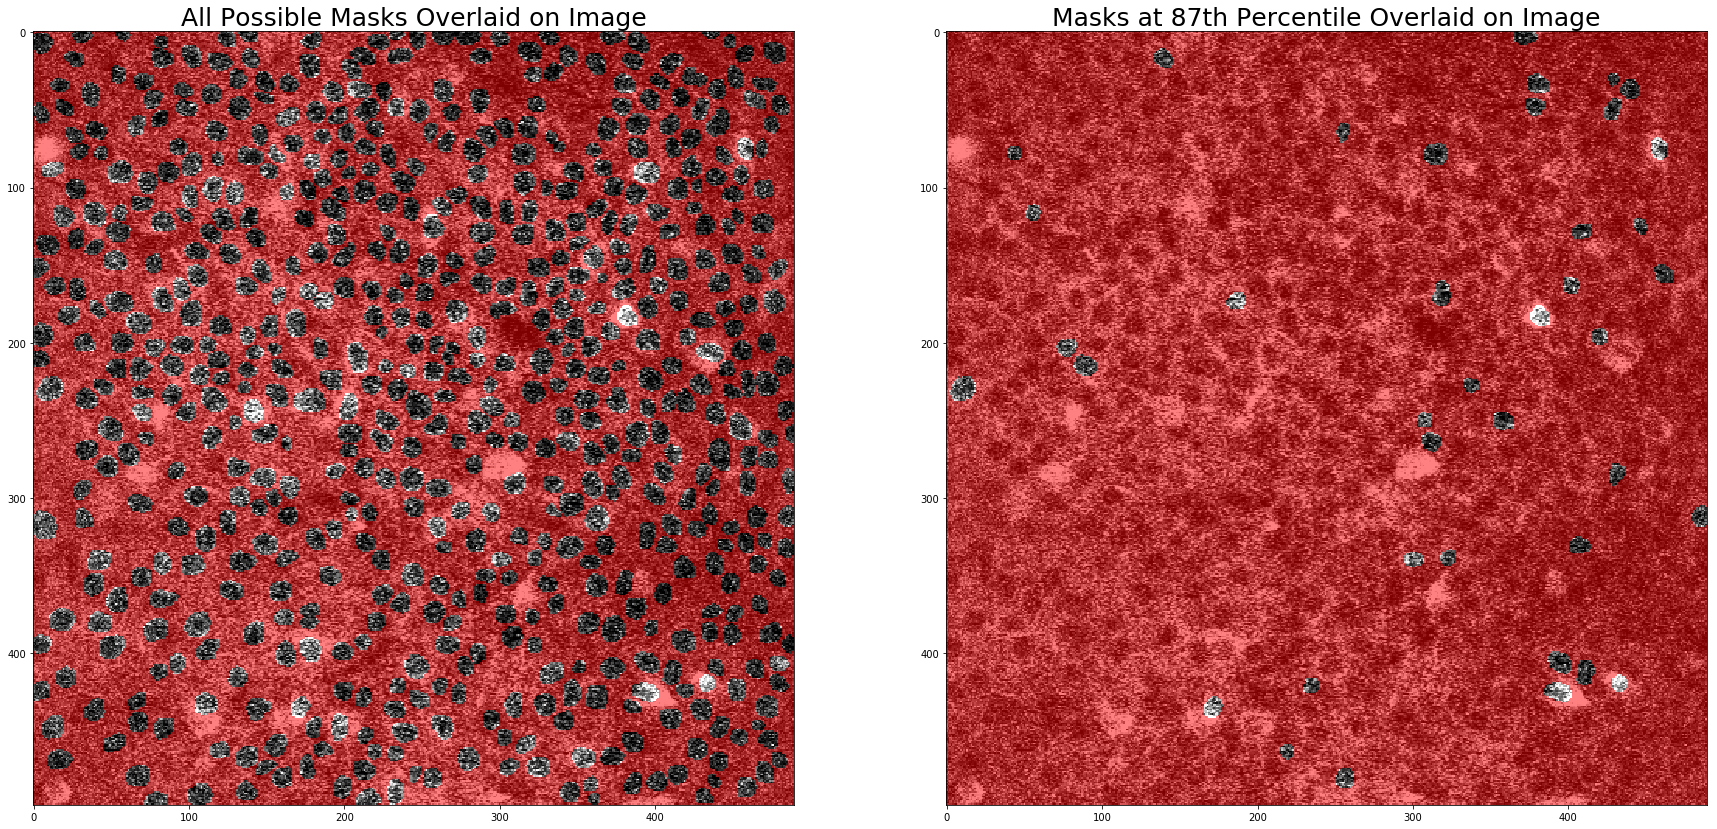

In [60]:
IMG_TO_PLOT = 2158
plt.figure(figsize=(30, 50))
plt.subplot(1,2,1)
plt.title("All Possible Masks Overlaid on Image", fontsize=25)
plt.imshow(imgs_300[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_300.sum(axis=0) == 0, masks_300.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv',alpha = .5)

plt.subplot(1,2,2)
plt.title("Masks at 87th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_300_percentile_87, imgs_300, IMG_TO_PLOT)

In [33]:
int(7/2 + .5)

4

In [34]:
# Is this sytlistically acceptable in python??
j = k = 4

In [ ]:
# TODO test when return

In [282]:
'''
-if input an odd number to total_time_filter_len i.e. 7 will take 7/2 --> 3.5 --> int(3.5 + .5) = 4
i.e. 8 will take 8/2 --> 4 --> int(4 + .5) = 4
int() just cuts off everything after 
'''
def time_filtered_and_percentile_selected_for_200s(percentile_selectivity, total_time_filter_len):
    mask_info = masks_200_info
    total_mask_array = masks_200
    img_stack = imgs_200
    TOTAL_NUM_TIME_STEPS = img_stack.shape[0]
    TOTAL_NUM_NEURONS = total_mask_array.shape[0]

    neuron_med_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'median')
    neuron_mean_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'mean')

    percentile_val_per_neuron_med = what_is_percentile_val_per_neuron(neuron_med_across_time, percentile_selectivity)
    percentile_val_per_neuron_mean = what_is_percentile_val_per_neuron(neuron_mean_across_time, percentile_selectivity)

    neuron_med_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_med, neuron_med_across_time)
    neuron_mean_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_mean, neuron_mean_across_time)
    
    combined_percentiles = combine_median_mean(neuron_med_above_percentile, neuron_mean_above_percentile)
    time_filtered_combined_percentiles = combined_percentiles
    
    #If the neuron is a lone neuron i.e. high in only one time stamp the the middle of the inputed filter size
    for row in range(0, time_filtered_combined_percentiles.shape[0]):
        len_on_either_side = int(total_time_filter_len/2 +.5)
        end_idx = time_filtered_combined_percentiles.shape[1] - len_on_either_side
        
        for col in range(len_on_either_side, end_idx):
            was_there_another_one = False;
            subset_of_neuron_v_time = time_filtered_combined_percentiles[row][col-len_on_either_side : col+len_on_either_side]
            if not np.where(subset_of_neuron_v_time == 1):
                time_filtered_combined_percentiles[row][col] = 0
                
        
#         for col in range(1, time_filtered_combined_percentiles.shape[1]-1):
#             if time_filtered_combined_percentiles[row][col-1] == 0:
#                 if time_filtered_combined_percentiles[row][col] == 1:
#                     if time_filtered_combined_percentiles[row][col+1] == 0:
#                          time_filtered_combined_percentiles[row][col] = 0
    
    
    
    all_masks = return_total_masks(np.transpose(time_filtered_combined_percentiles), masks_200, imgs_200)
    
    return all_masks

In [ ]:
# TODO make an input where you can choose how many indicies to time filter
# save the whole movie

In [ ]:
# The median array is not the same as the mean or sum array
# But the mean and sum array for percentile cutoffs are the same --> DUHHHHH

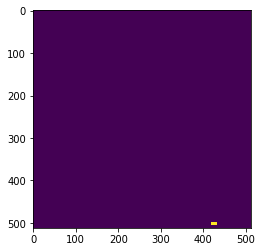

0
Press Enter to continue...


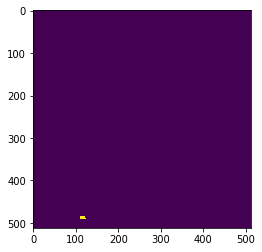

1
Press Enter to continue...


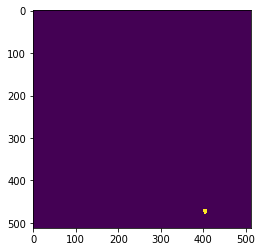

2
Press Enter to continue...


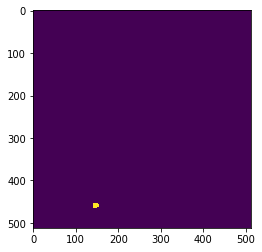

3
Press Enter to continue...


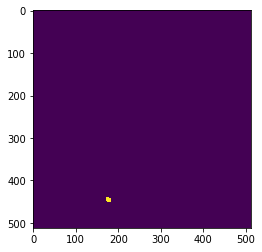

4
Press Enter to continue...


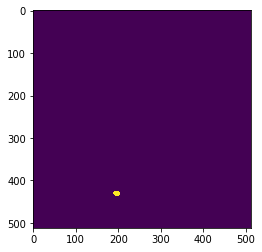

5
Press Enter to continue...


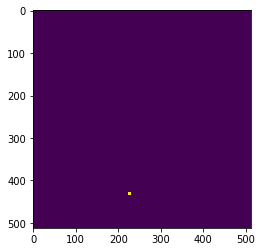

6
Press Enter to continue...


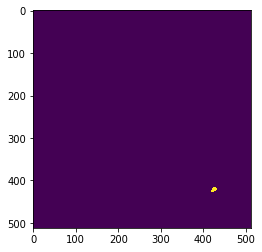

7
Press Enter to continue...


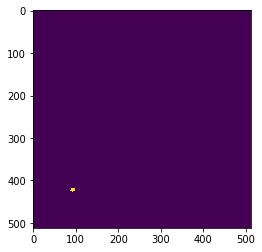

8
Press Enter to continue...


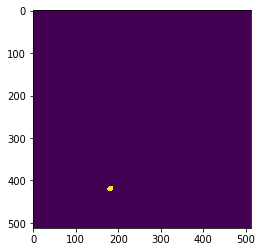

9
Press Enter to continue...


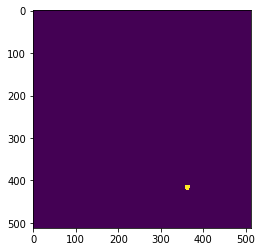

10
Press Enter to continue...


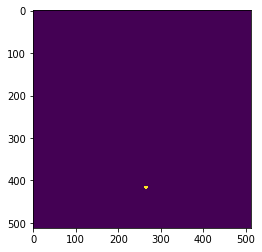

11
Press Enter to continue...


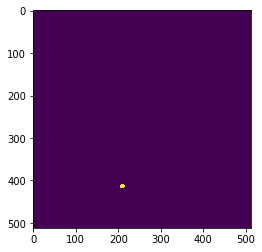

12
Press Enter to continue...


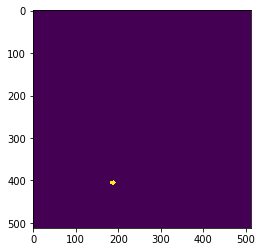

13
Press Enter to continue...


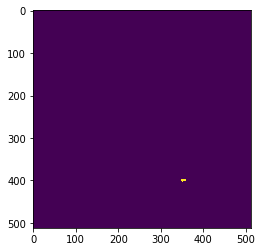

14
Press Enter to continue...


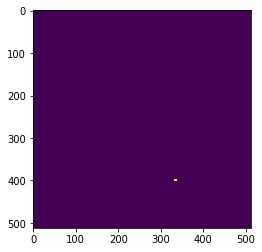

15
Press Enter to continue...


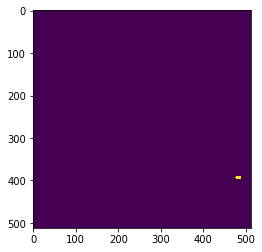

16
Press Enter to continue...


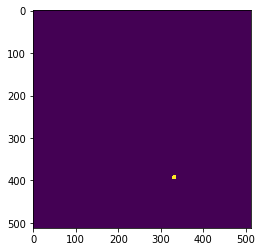

17
Press Enter to continue...


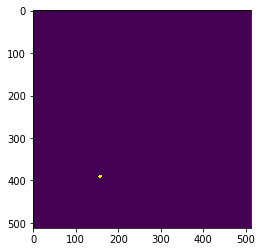

18
Press Enter to continue...


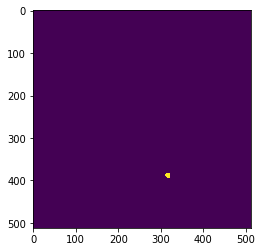

19
Press Enter to continue...


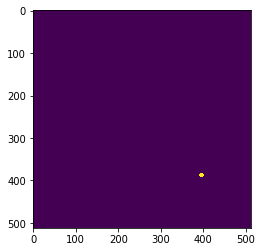

20
Press Enter to continue...


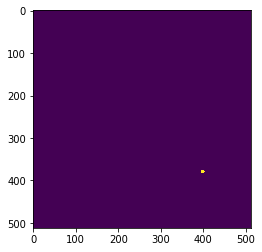

21
Press Enter to continue...


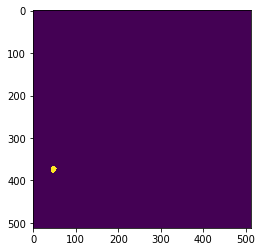

22
Press Enter to continue...


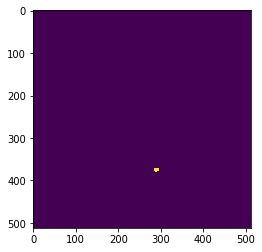

23
Press Enter to continue...


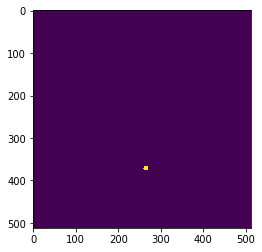

24
Press Enter to continue...


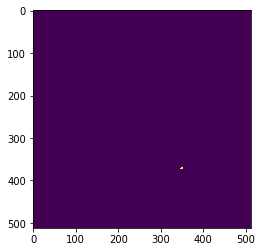

25
Press Enter to continue...


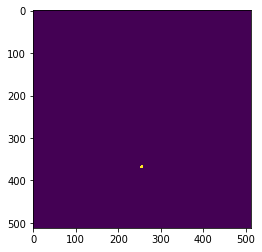

26
Press Enter to continue...


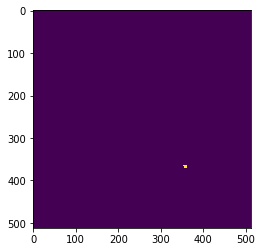

27
Press Enter to continue...


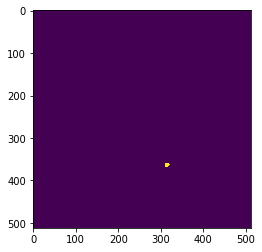

28
Press Enter to continue...


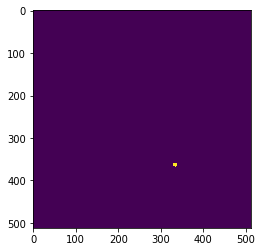

29
Press Enter to continue...


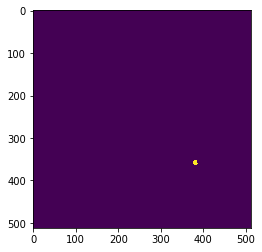

30
Press Enter to continue...


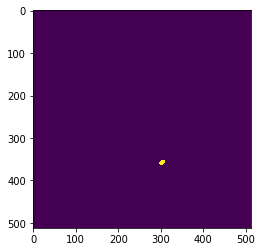

31
Press Enter to continue...


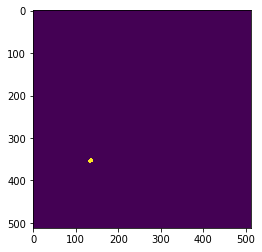

32
Press Enter to continue...


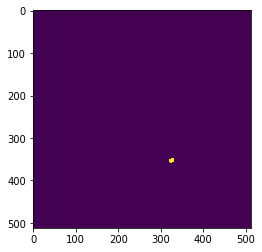

33
Press Enter to continue...


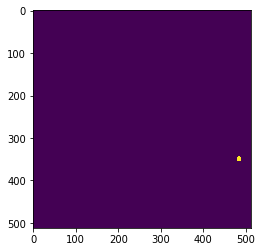

34
Press Enter to continue...


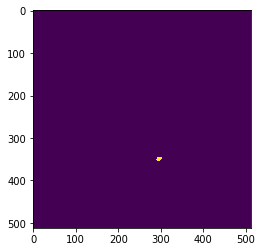

35
Press Enter to continue...


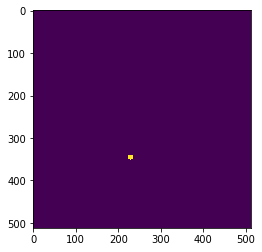

36
Press Enter to continue...


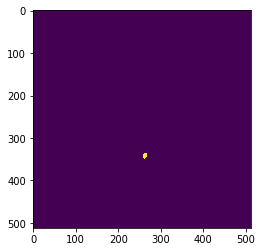

37
Press Enter to continue...


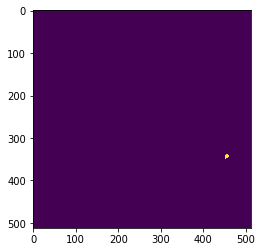

38
Press Enter to continue...


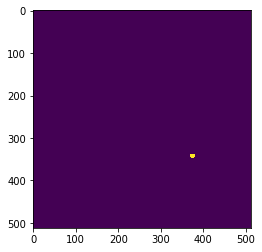

39
Press Enter to continue...


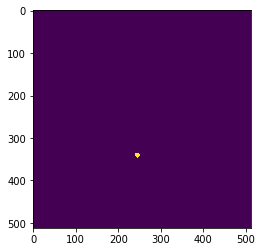

40
Press Enter to continue...


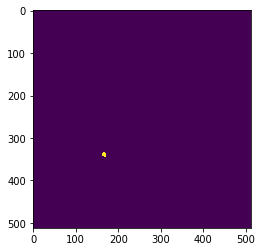

41
Press Enter to continue...


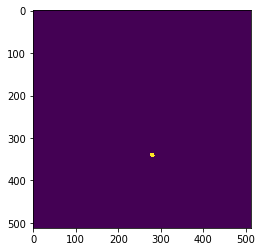

42
Press Enter to continue...


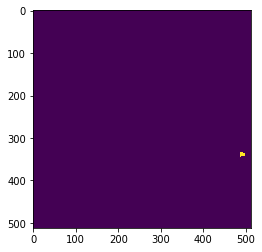

43
Press Enter to continue...


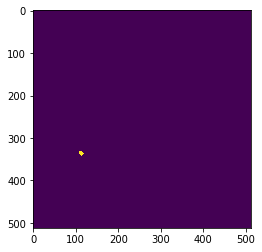

44
Press Enter to continue...


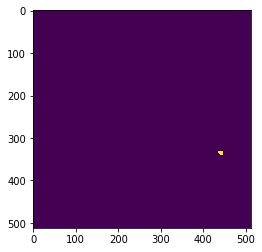

45
Press Enter to continue...


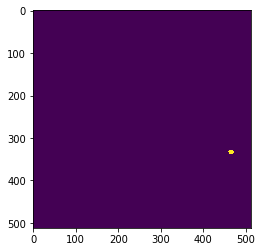

46
Press Enter to continue...


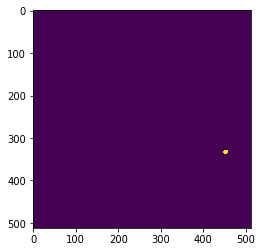

47
Press Enter to continue...


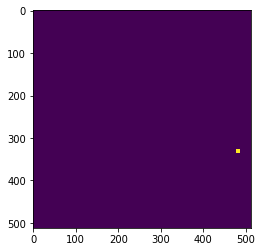

48
Press Enter to continue...


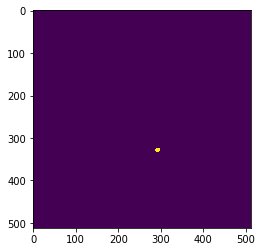

49
Press Enter to continue...


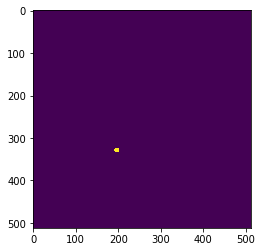

50
Press Enter to continue...


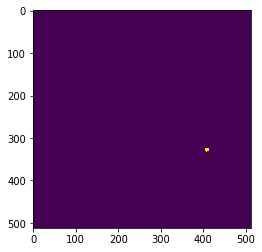

51
Press Enter to continue...


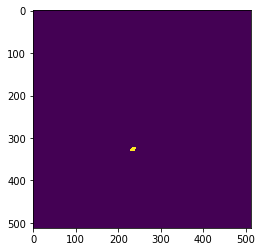

52
Press Enter to continue...


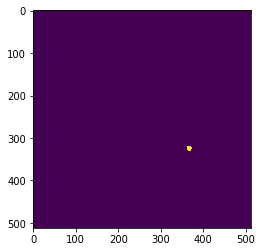

53
Press Enter to continue...


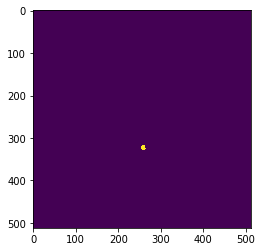

54
Press Enter to continue...


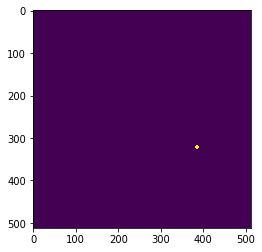

55
Press Enter to continue...


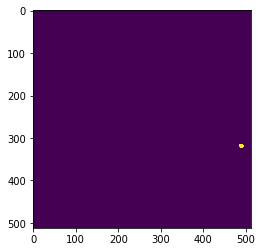

56
Press Enter to continue...


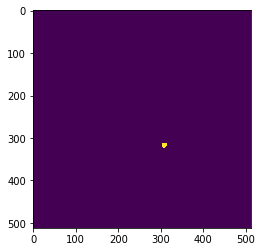

57
Press Enter to continue...


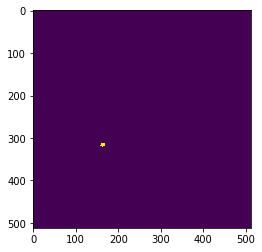

58
Press Enter to continue...


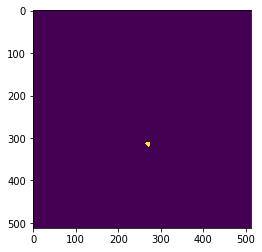

59
Press Enter to continue...


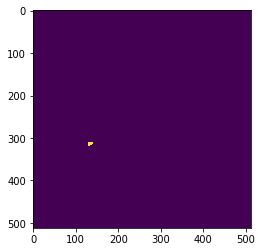

60
Press Enter to continue...


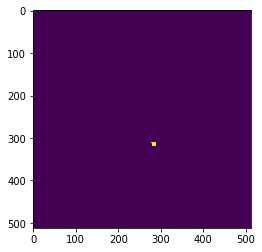

61
Press Enter to continue...


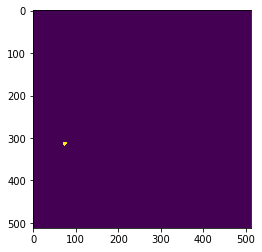

62
Press Enter to continue...


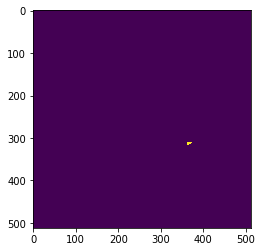

63
Press Enter to continue...


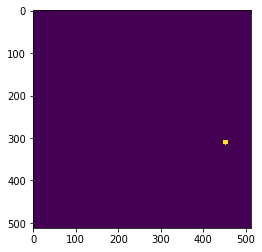

64
Press Enter to continue...


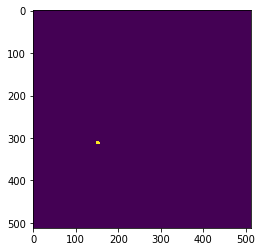

65
Press Enter to continue...


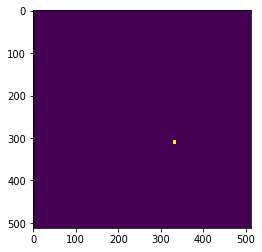

66
Press Enter to continue...


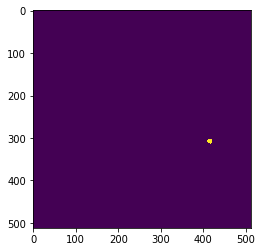

67
Press Enter to continue...


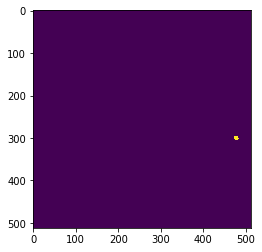

68
Press Enter to continue...


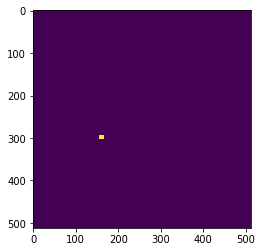

69
Press Enter to continue...


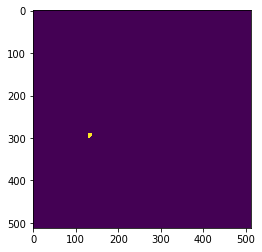

70
Press Enter to continue...


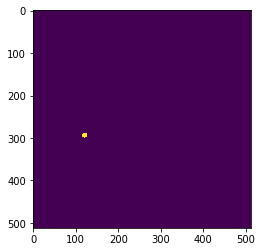

71
Press Enter to continue...


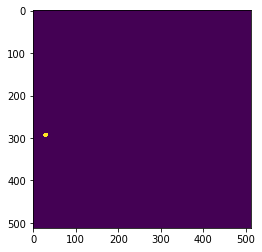

72
Press Enter to continue...


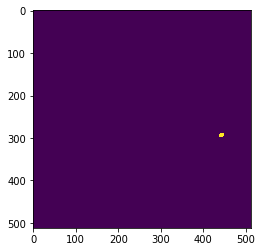

73
Press Enter to continue...


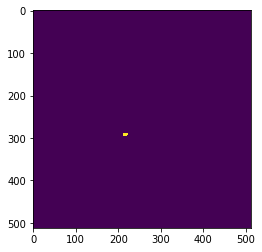

74
Press Enter to continue...


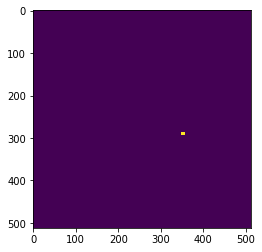

75
Press Enter to continue...


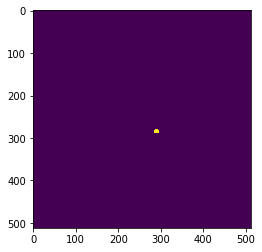

76
Press Enter to continue...


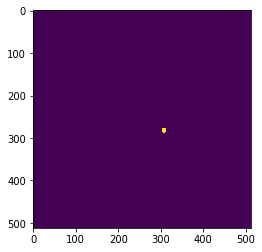

77
Press Enter to continue...


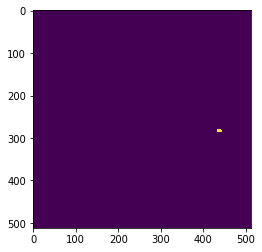

78
Press Enter to continue...


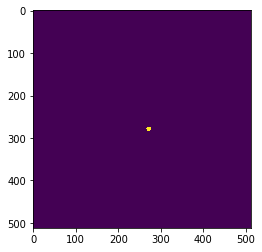

79
Press Enter to continue...


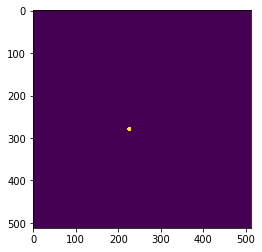

80
Press Enter to continue...


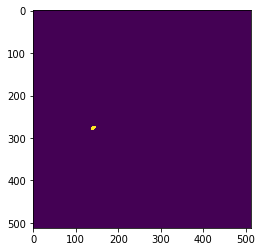

81
Press Enter to continue...


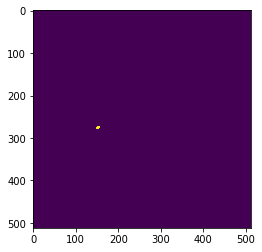

82
Press Enter to continue...


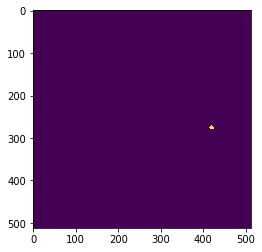

83
Press Enter to continue...


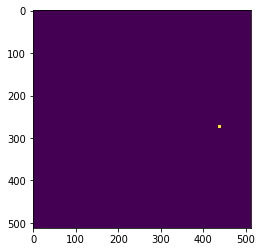

84
Press Enter to continue...


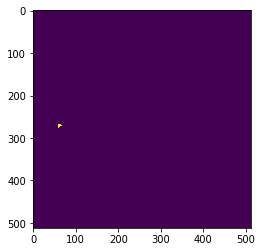

85
Press Enter to continue...


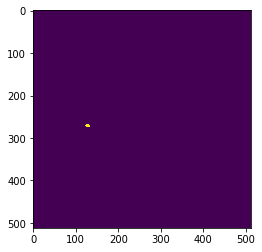

86
Press Enter to continue...


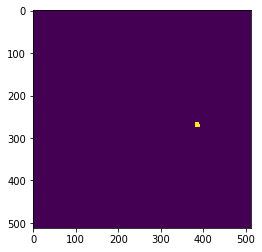

87
Press Enter to continue...


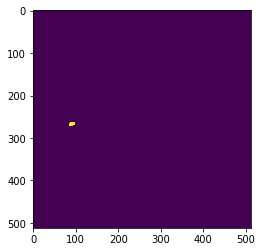

88
Press Enter to continue...


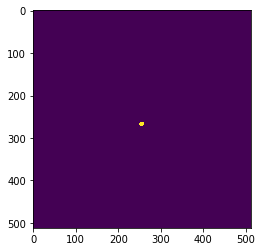

89
Press Enter to continue...


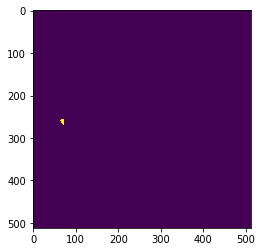

90
Press Enter to continue...


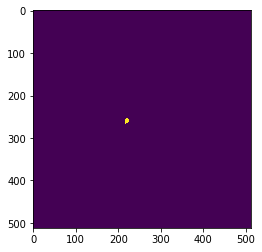

91
Press Enter to continue...


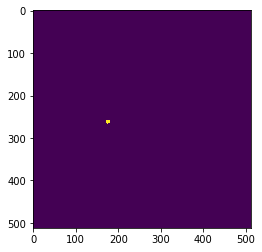

92
Press Enter to continue...


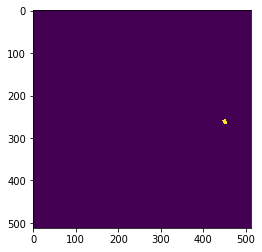

93
Press Enter to continue...


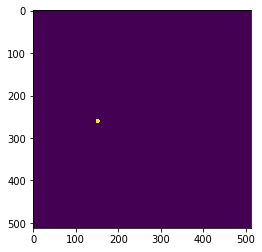

94
Press Enter to continue...


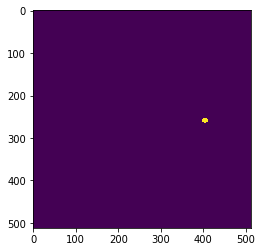

95
Press Enter to continue...


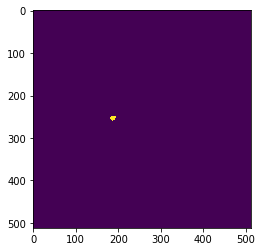

96
Press Enter to continue...


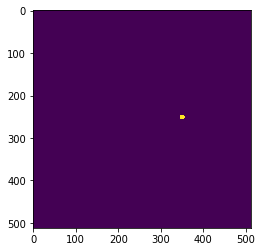

97
Press Enter to continue...


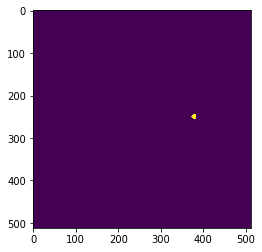

98
Press Enter to continue...


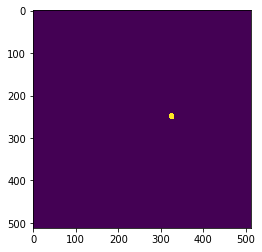

99
Press Enter to continue...


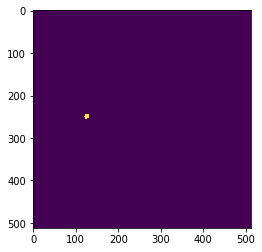

100
Press Enter to continue...


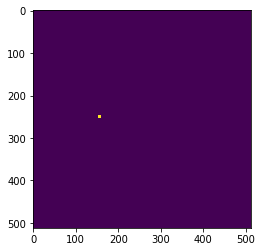

101
Press Enter to continue...


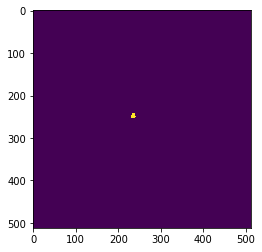

102
Press Enter to continue...


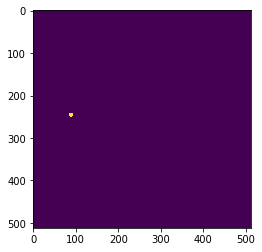

103
Press Enter to continue...


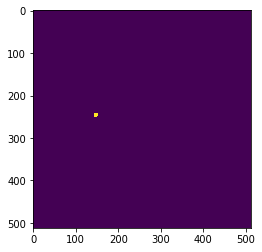

104
Press Enter to continue...


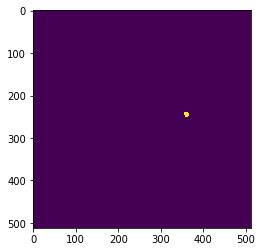

105
Press Enter to continue...


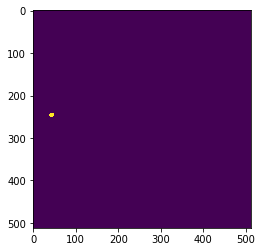

106
Press Enter to continue...


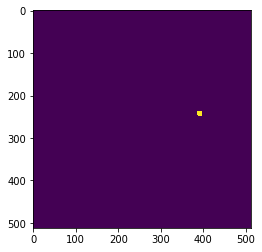

107
Press Enter to continue...


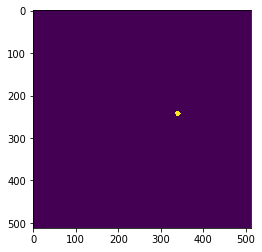

108
Press Enter to continue...


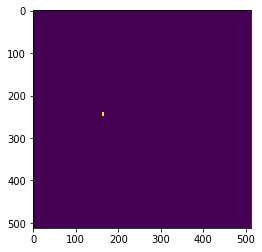

109
Press Enter to continue...


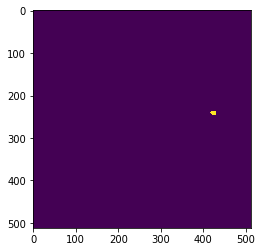

110
Press Enter to continue...


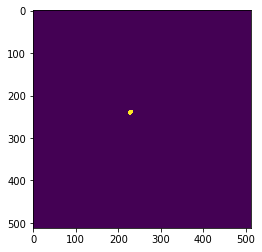

111
Press Enter to continue...


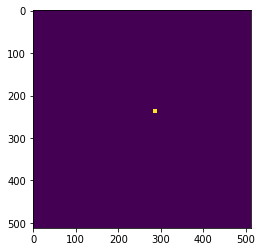

112
Press Enter to continue...


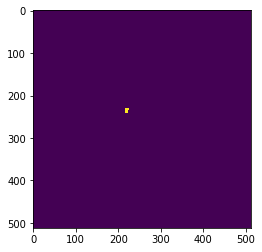

113
Press Enter to continue...


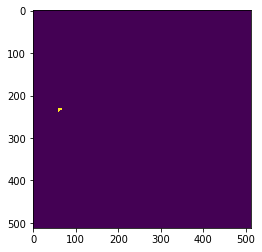

114
Press Enter to continue...


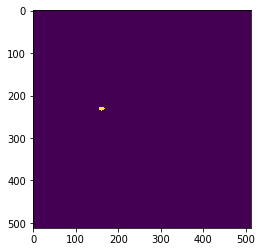

115
Press Enter to continue...


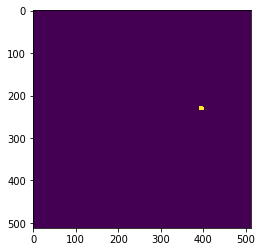

116
Press Enter to continue...


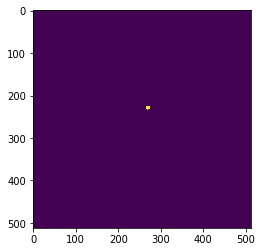

117
Press Enter to continue...


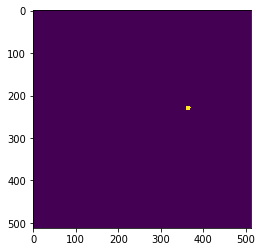

118
Press Enter to continue...


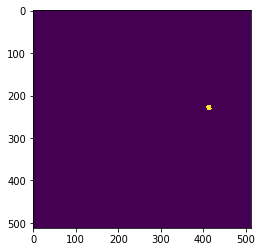

119
Press Enter to continue...


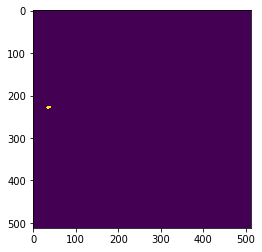

120
Press Enter to continue...


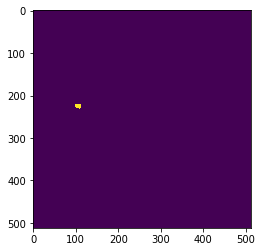

121
Press Enter to continue...


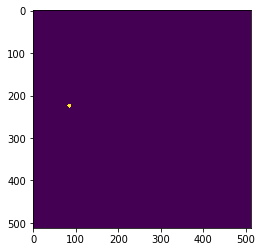

122
Press Enter to continue...


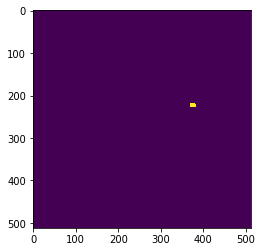

123
Press Enter to continue...


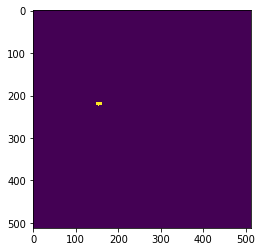

124
Press Enter to continue...


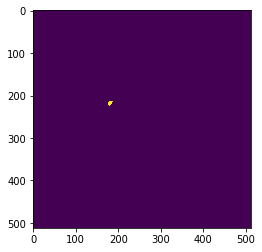

125
Press Enter to continue...


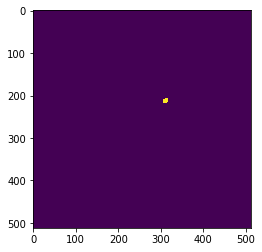

126
Press Enter to continue...


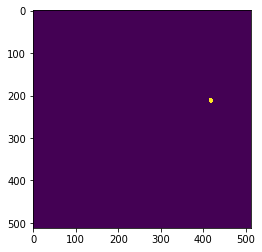

127
Press Enter to continue...


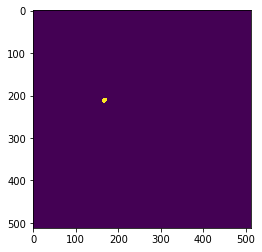

128
Press Enter to continue...


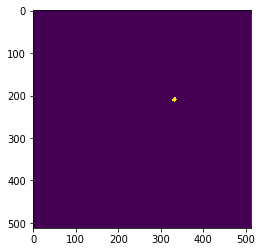

129
Press Enter to continue...


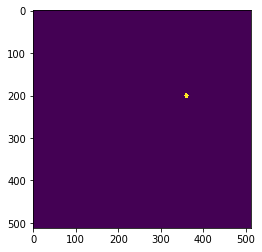

130
Press Enter to continue...


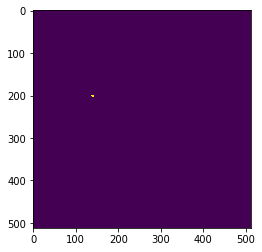

131
Press Enter to continue...


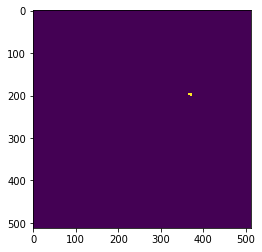

132
Press Enter to continue...


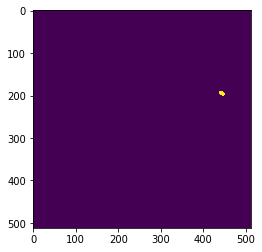

133
Press Enter to continue...


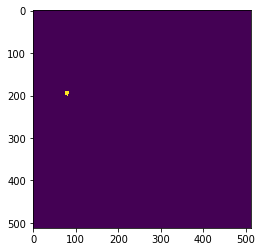

134
Press Enter to continue...


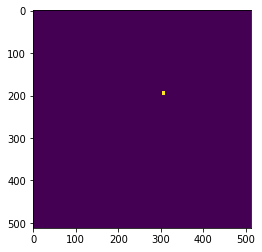

135
Press Enter to continue...


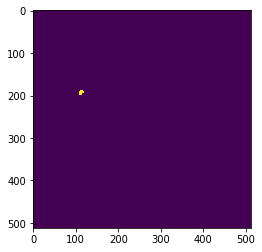

136
Press Enter to continue...


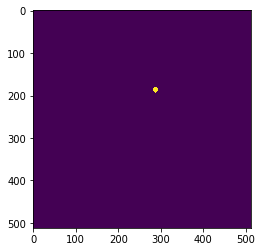

137
Press Enter to continue...


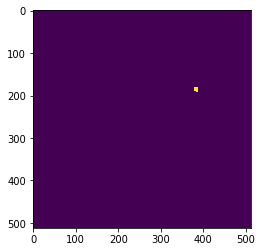

138
Press Enter to continue...


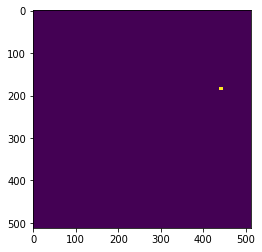

139
Press Enter to continue...


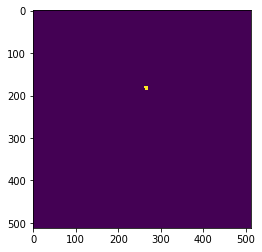

140
Press Enter to continue...


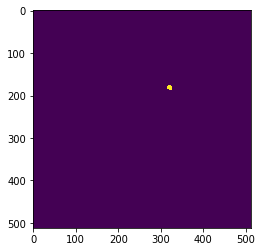

141
Press Enter to continue...


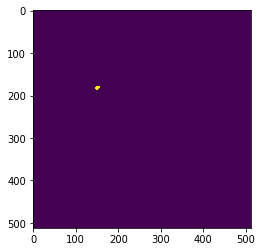

142
Press Enter to continue...


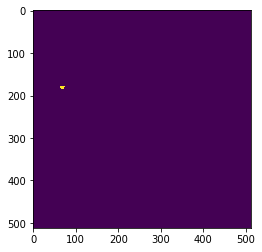

143
Press Enter to continue...


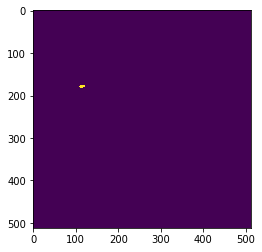

144
Press Enter to continue...


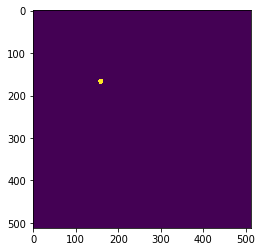

145
Press Enter to continue...


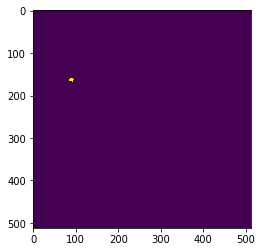

146
Press Enter to continue...


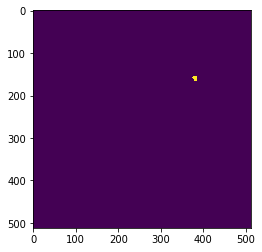

147
Press Enter to continue...


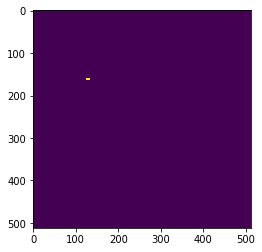

148
Press Enter to continue...


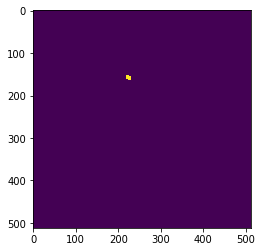

149
Press Enter to continue...


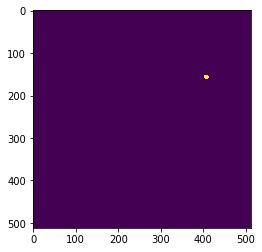

150
Press Enter to continue...


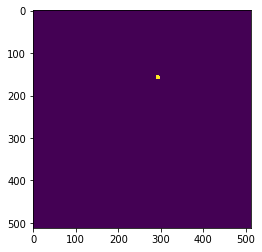

151
Press Enter to continue...


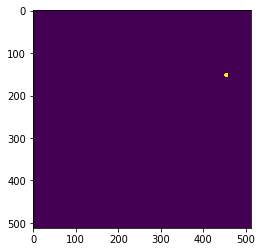

152
Press Enter to continue...


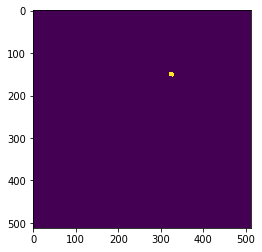

153
Press Enter to continue...


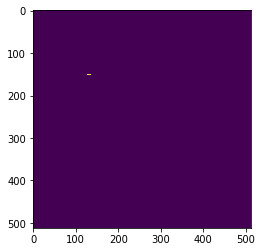

154
Press Enter to continue...


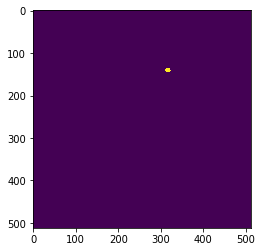

155
Press Enter to continue...


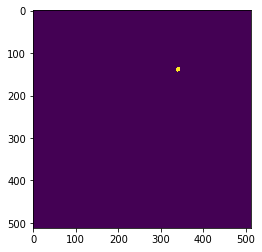

156
Press Enter to continue...


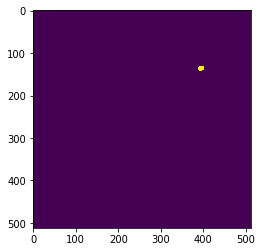

157
Press Enter to continue...


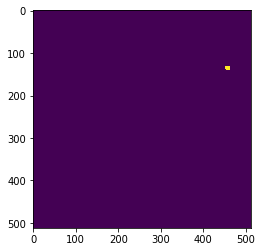

158
Press Enter to continue...


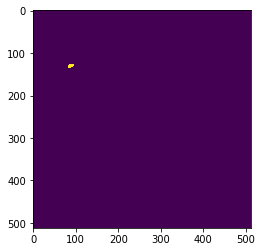

159
Press Enter to continue...


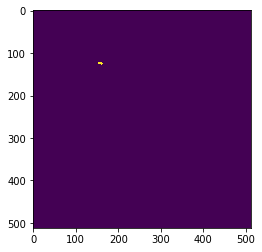

160
Press Enter to continue...


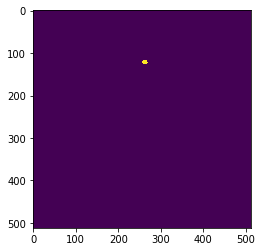

161
Press Enter to continue...


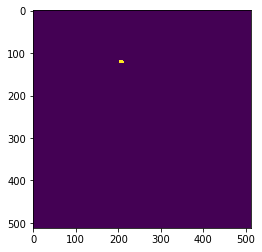

162
Press Enter to continue...


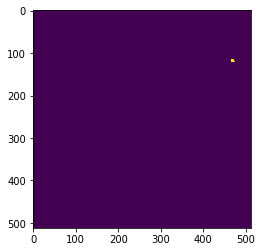

163
Press Enter to continue...


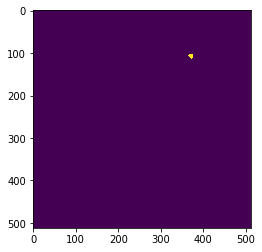

164
Press Enter to continue...


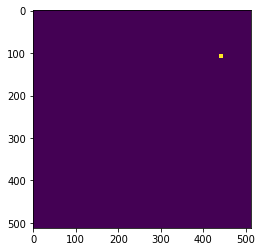

165
Press Enter to continue...


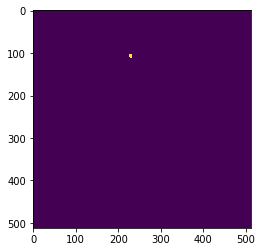

166
Press Enter to continue...


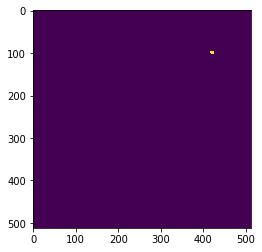

167
Press Enter to continue...


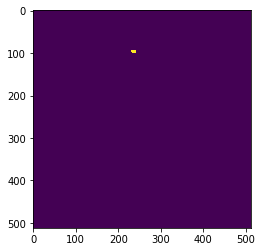

168
Press Enter to continue...


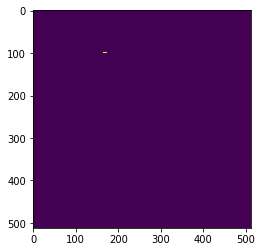

169
Press Enter to continue...


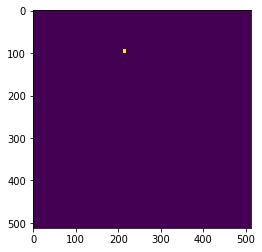

170
Press Enter to continue...


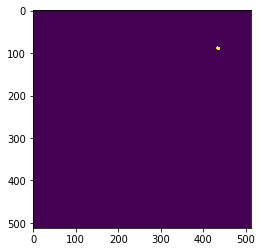

171
Press Enter to continue...


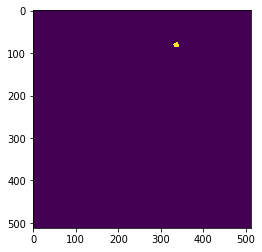

172
Press Enter to continue...


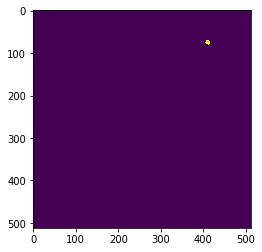

173
Press Enter to continue...


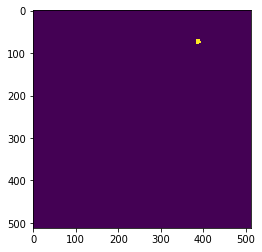

174
Press Enter to continue...


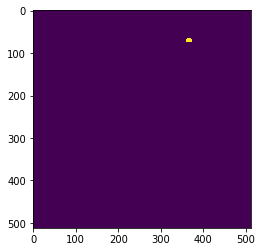

175
Press Enter to continue...


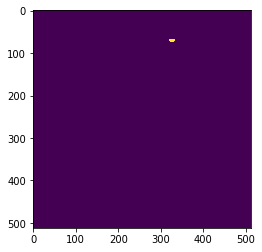

176
Press Enter to continue...


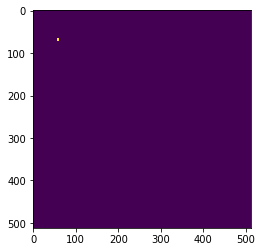

177
Press Enter to continue...


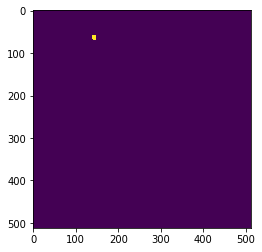

178
Press Enter to continue...


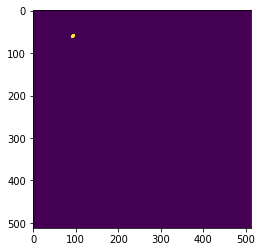

179
Press Enter to continue...


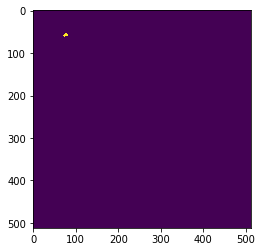

180
Press Enter to continue...


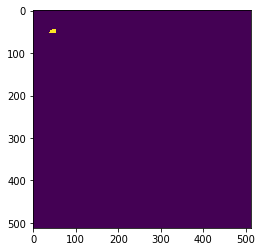

181
Press Enter to continue...


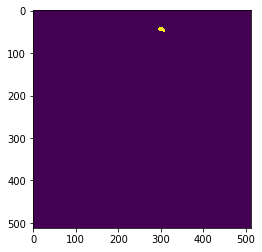

182
Press Enter to continue...


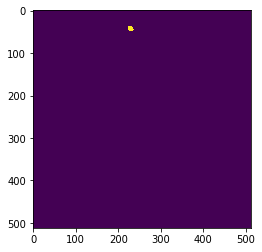

183
Press Enter to continue...


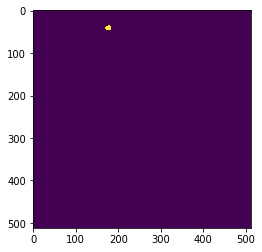

184
Press Enter to continue...


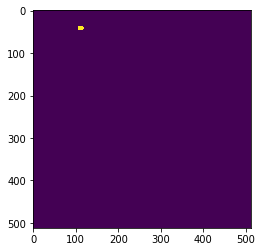

185
Press Enter to continue...


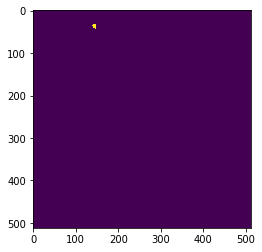

186
Press Enter to continue...


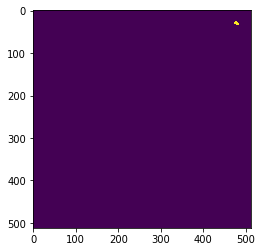

187
Press Enter to continue...


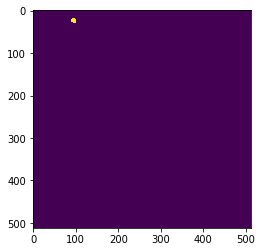

188
Press Enter to continue...


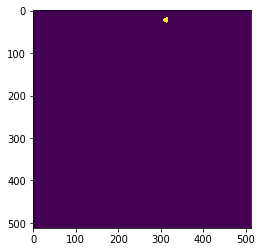

189
Press Enter to continue...


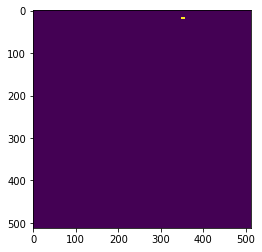

190
Press Enter to continue...


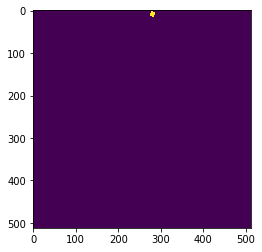

191
Press Enter to continue...


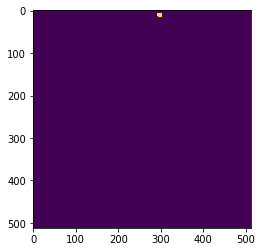

192
Press Enter to continue...


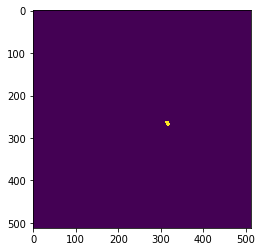

193
Press Enter to continue...


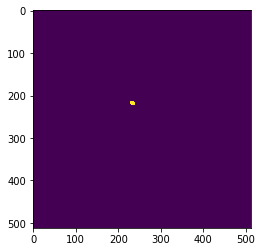

194
Press Enter to continue...


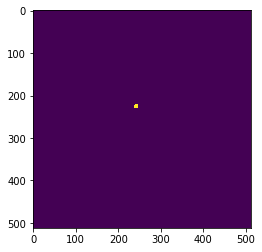

195
Press Enter to continue...


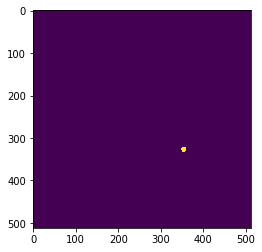

196
Press Enter to continue...


In [124]:
for idx in range(0, TOTAL_NUM_NEURONS):
    plt.imshow(total_mask_array[idx, :, :])
    plt.show()
    print(idx)
    input("Press Enter to continue...")

# 178 and 180 are promissing to look at

In [157]:
NUM_NEURON_EXPLORING = 180
percentile_value_per_neuron[NUM_NEURON_EXPLORING]

array([0.])

In [65]:
test = generate_all_masks(masks_200_info, masks_200, imgs_200, 'median', 95)

entered function
TOTAL_NUM_TIME_STEPS = 8000, TOTAL_NUM_NEURONS = 197
post neuron eval
post percentile gen
found indicies above percentile
found all masks per image


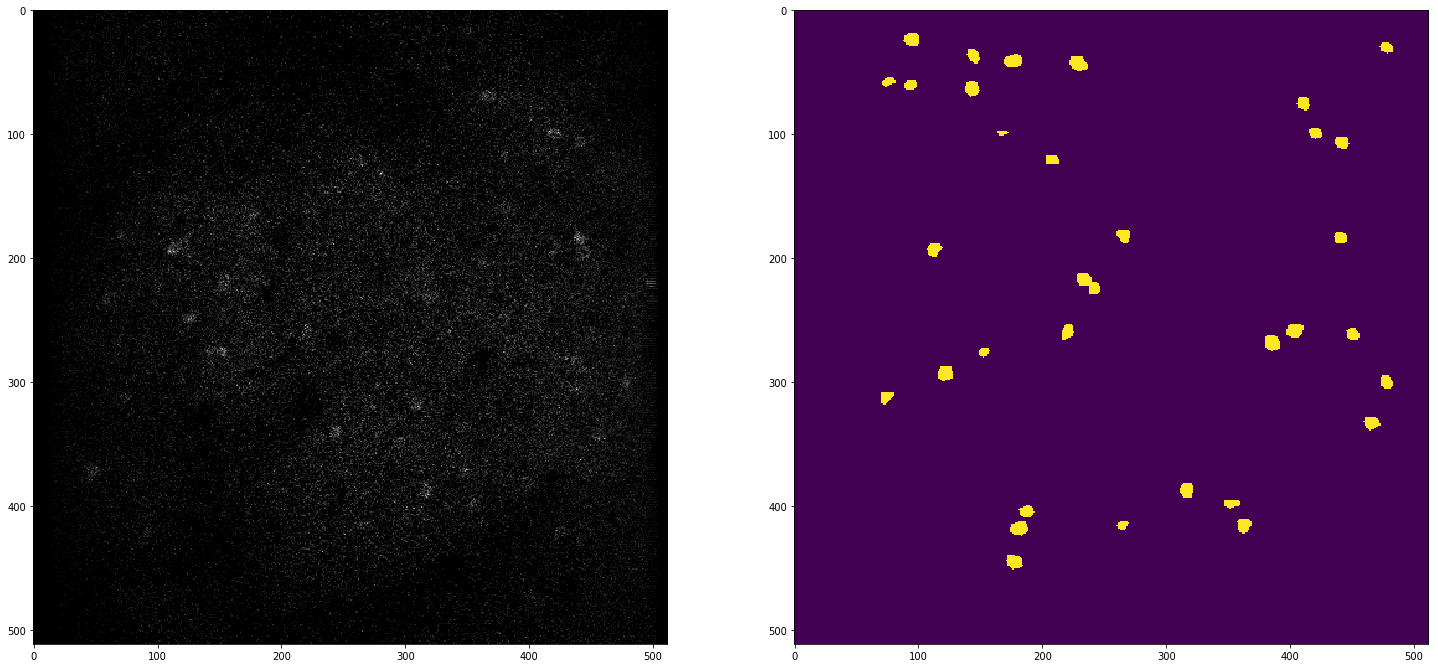

In [255]:
# helpful to show what I am plotting
plt.figure(figsize=(25,16))
plt.subplot(1,2,1)
plt.imshow(imgs_200[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test[0])

In [ ]:
# Take time series into account 

In [ ]:
# PLOT the values that I have missed: try to see what is going on

In [283]:
masks_200_percentile_85_and_time_filtered = time_filtered_and_percentile_selected_for_200s(85)

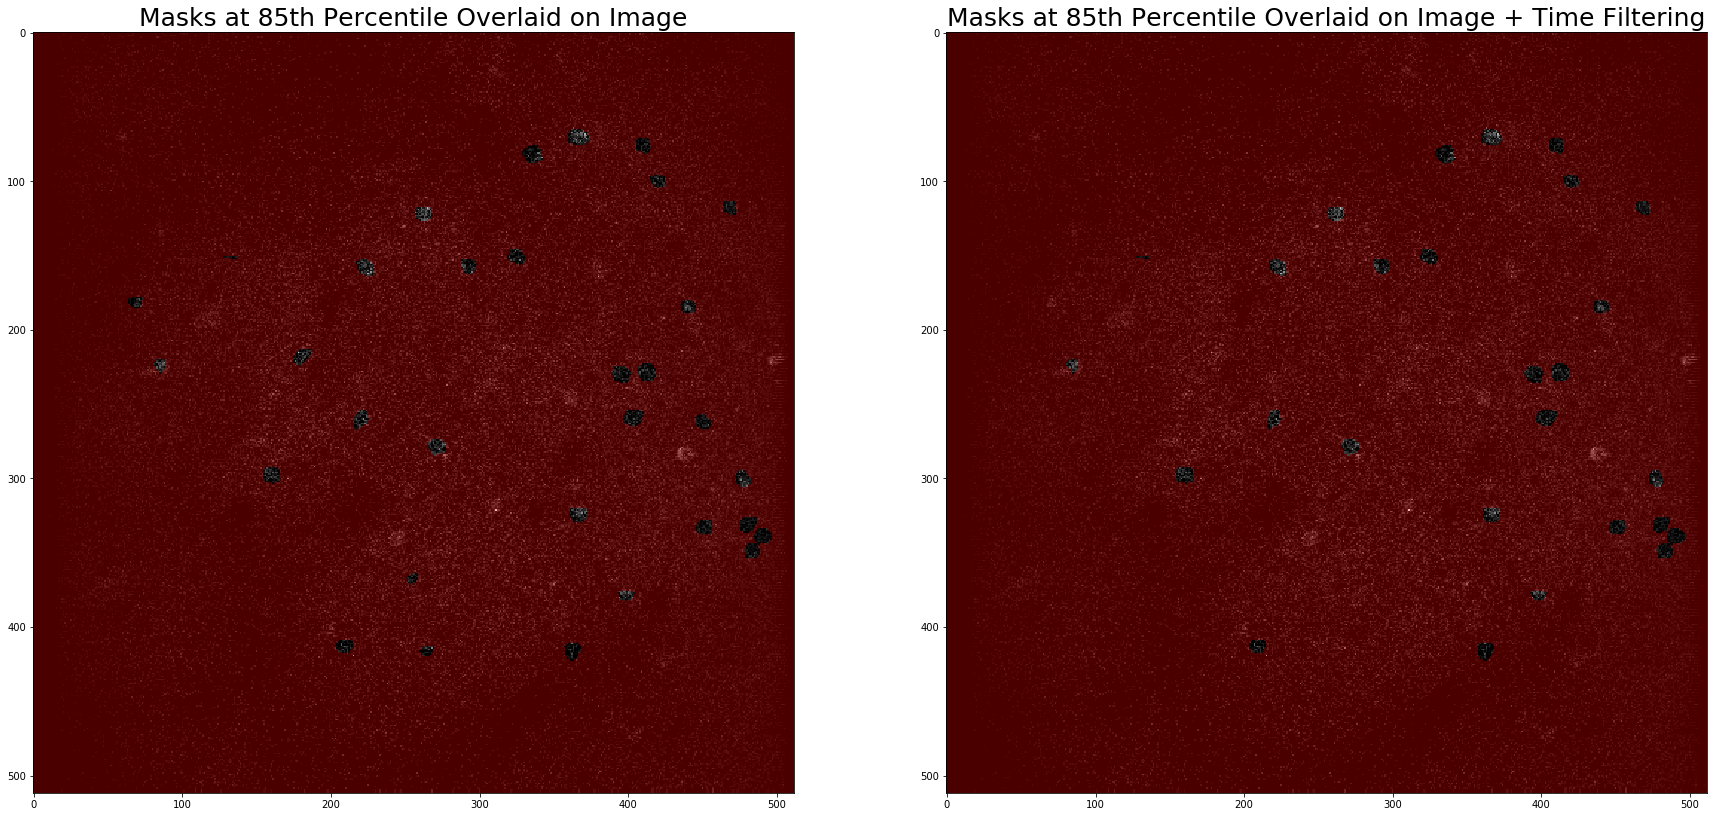

In [285]:
IMG_TO_PLOT = 200
plt.figure(figsize=(30, 50))
plt.subplot(1,2,1)
plt.title("Masks at 85th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_85, imgs_200, IMG_TO_PLOT)

plt.subplot(1,2,2)
plt.title("Masks at 85th Percentile Overlaid on Image + Time Filtering", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_85_and_time_filtered, imgs_200, IMG_TO_PLOT)


In [232]:
masks_200_percentile_95 = temp_which_percentile_for_200s(95)
masks_200_percentile_90 = temp_which_percentile_for_200s(90)
masks_200_percentile_85 = temp_which_percentile_for_200s(85)
masks_200_percentile_80 = temp_which_percentile_for_200s(80)

In [36]:
masks_200_percentile_87 = temp_which_percentile_for_200s(87)

NameError: name 'neuron_eval_across_time' is not defined

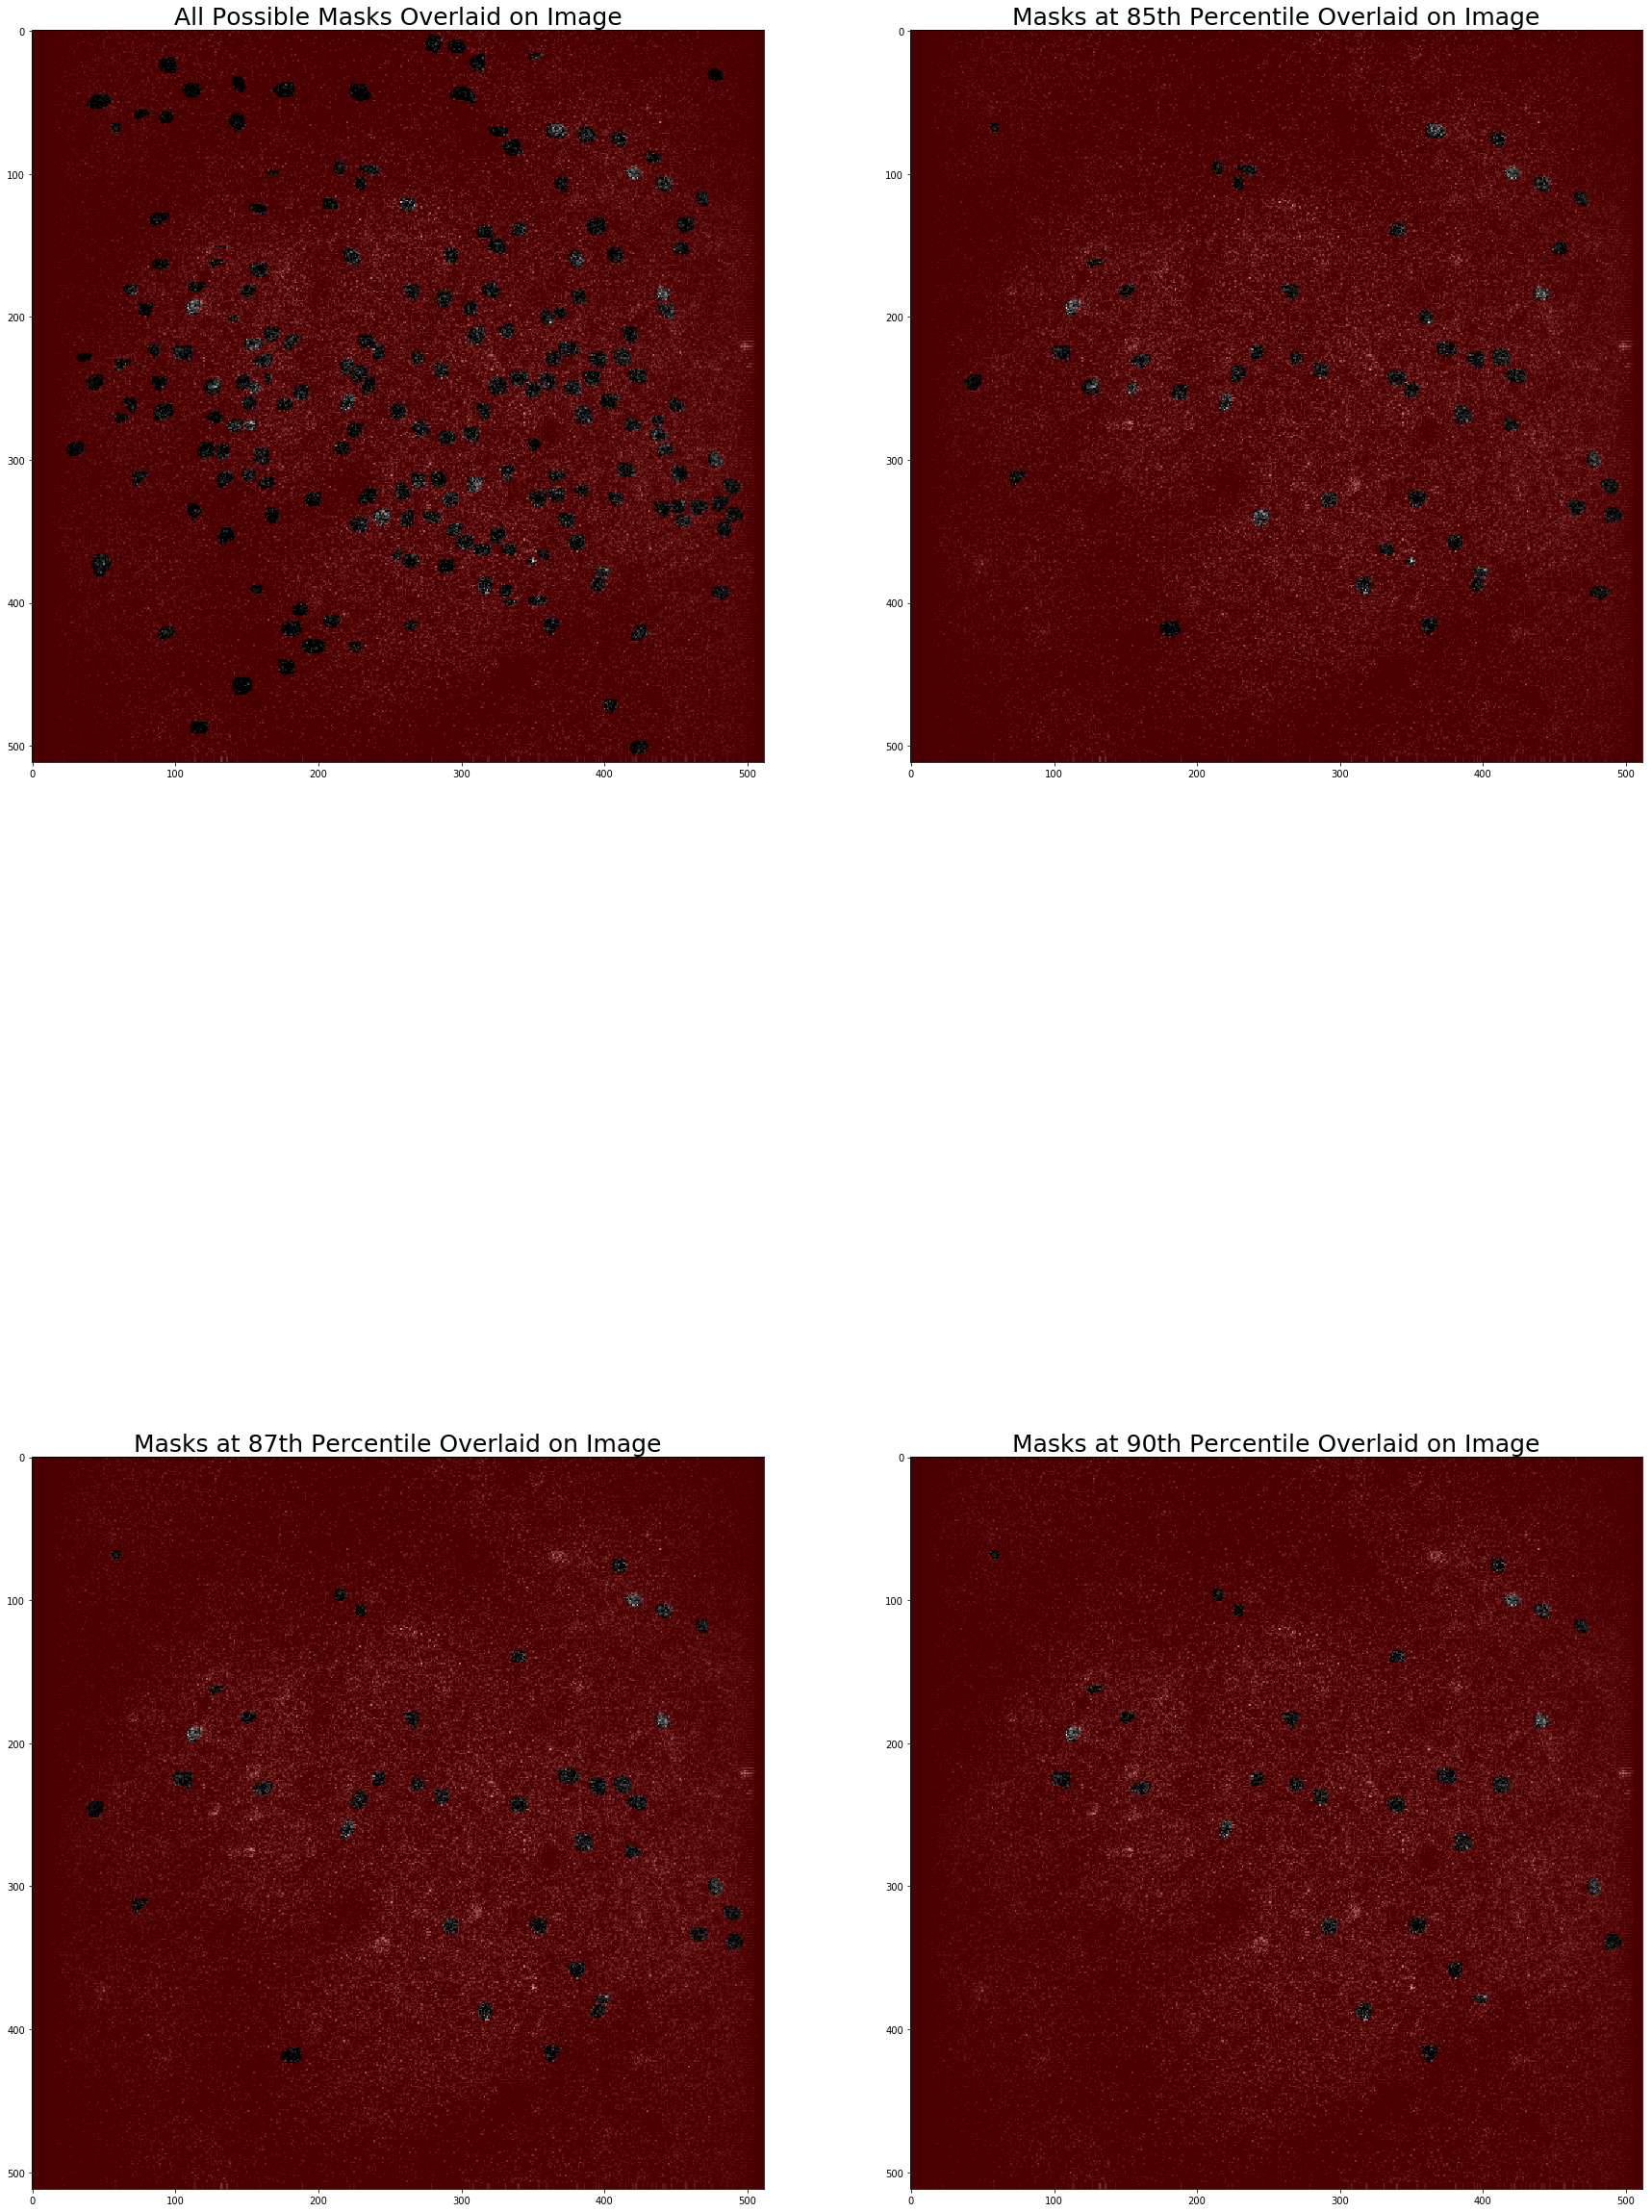

In [254]:
IMG_TO_PLOT = 1
plt.figure(figsize=(30, 50))
plt.subplot(2,2,1)
plt.title("All Possible Masks Overlaid on Image", fontsize=25)
plt.imshow(imgs_200[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_200.sum(axis=0) == 0, masks_200.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv',alpha = .3)

plt.subplot(2,2,2)
plt.title("Masks at 85th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_85, imgs_200, IMG_TO_PLOT)

plt.subplot(2,2,3)
plt.title("Masks at 87th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_87, imgs_200, IMG_TO_PLOT)

plt.subplot(2,2,4)
plt.title("Masks at 90th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_90, imgs_200, IMG_TO_PLOT)



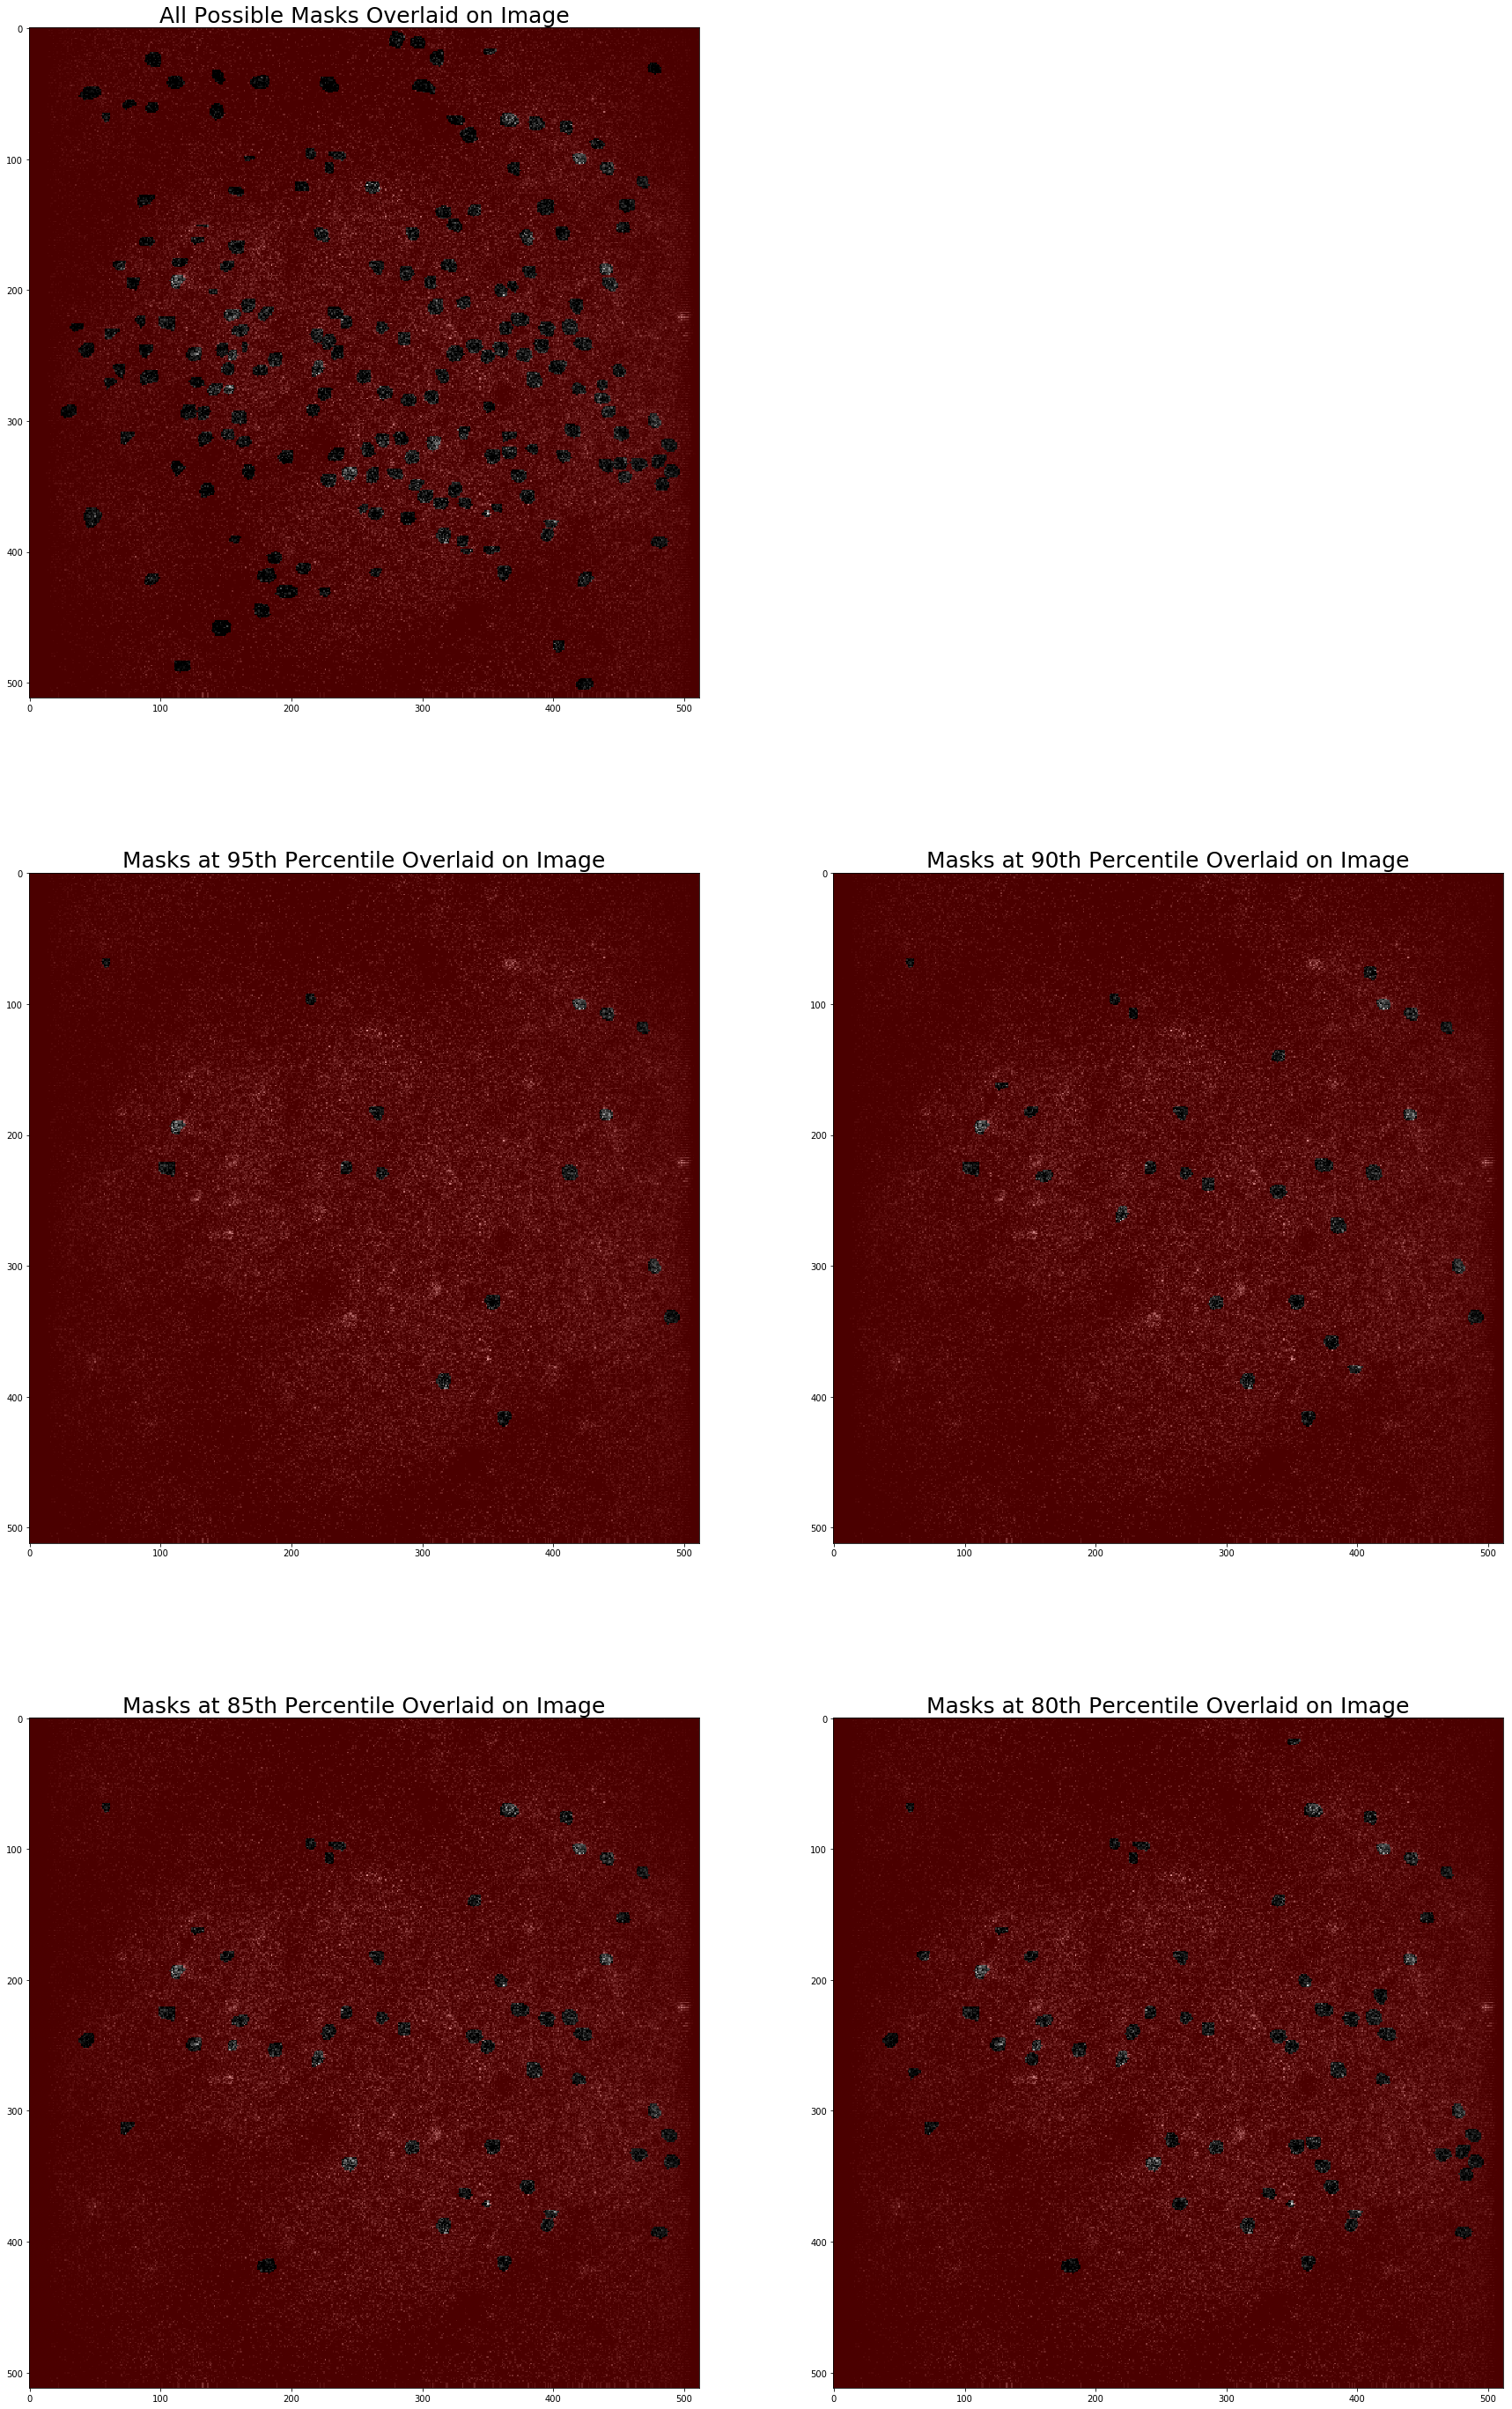

In [252]:
IMG_TO_PLOT = 1
plt.figure(figsize=(30, 50))
plt.subplot(3,2,1)
plt.title("All Possible Masks Overlaid on Image", fontsize=25)
plt.imshow(imgs_200[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_200.sum(axis=0) == 0, masks_200.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv',alpha = .3)

plt.subplot(3,2,3)
plt.title("Masks at 95th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_95, imgs_200, IMG_TO_PLOT)

plt.subplot(3,2,4)
plt.title("Masks at 90th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_90, imgs_200, IMG_TO_PLOT)

plt.subplot(3,2,5)
plt.title("Masks at 85th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_85, imgs_200, IMG_TO_PLOT)

plt.subplot(3,2,6)
plt.title("Masks at 80th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(masks_200_percentile_80, imgs_200, IMG_TO_PLOT)


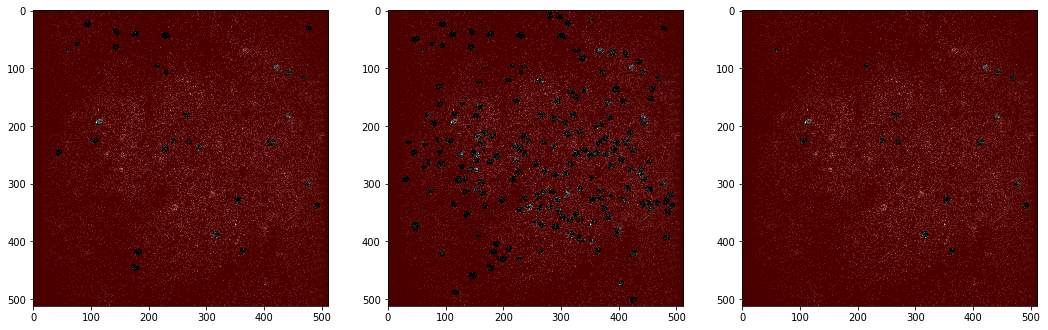

In [221]:
IMG_TO_PLOT = 1
plt.figure(figsize=(18,16))
plt.subplot(1,3,1)
plot_total_mask_over_img_slice(test, imgs_200, IMG_TO_PLOT)
plt.subplot(1,3,2)
plt.imshow(imgs_200[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_200.sum(axis=0) == 0, masks_200.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv',alpha = .3)
plt.subplot(1,3,3)
plot_total_mask_over_img_slice(all_masks, imgs_200, IMG_TO_PLOT)

<font size='+3'>
DO NOT RERUN FOLLOWING PLOT
    <br>
it demonstrates what just median looks like @ 95%
</font>

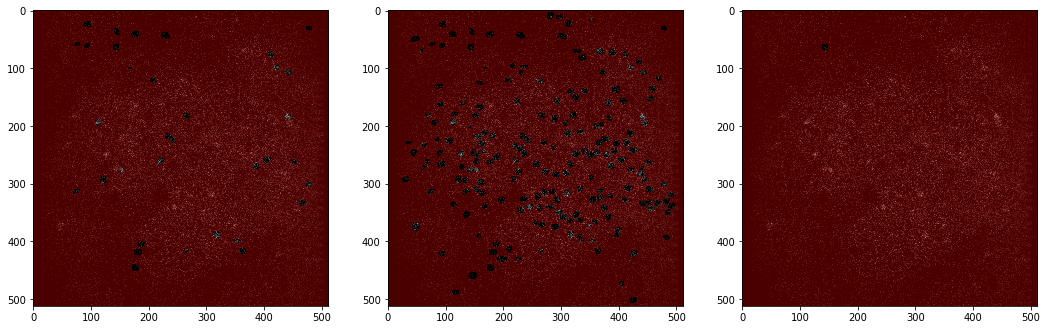

In [127]:
IMG_TO_PLOT = 0
plt.figure(figsize=(18,16))
plt.subplot(1,3,1)
plot_total_mask_over_img_slice(test, imgs_200, IMG_TO_PLOT)
plt.subplot(1,3,2)
plt.imshow(imgs_200[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_200.sum(axis=0) == 0, masks_200.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv',alpha = .3)
plt.subplot(1,3,3)
plt.imshow(imgs_200[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_200[NUM_NEURON_EXPLORING] == 0, masks_200[NUM_NEURON_EXPLORING])
plt.imshow(Mask, cmap = 'hsv',alpha = .3)


In [55]:
def plot_total_mask_over_img_slice(total_masks, all_imgs, img_idx):
    plt.imshow(all_imgs[img_idx,:,:], cmap = 'gray')
    Mask = np.ma.masked_array(total_masks[img_idx, :, :] == 0, total_masks[img_idx, :, :])
    plt.imshow(Mask, cmap = 'hsv',alpha = .5)

In [ ]:
# Take time series into account when generating the masks: